## Import library

In [3463]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import xarray as xr
import xclim
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3464]:
## Set working directory
os.chdir('/mys3bucket/cdd_output/CDD/')

In [3465]:
# import land mask
mask=xr.open_dataset('/mys3bucket/ERA_Temp/mask_new.nc')['region']

In [3466]:
## Open climatic zone shapefiles

In [3467]:
sudanian_zone= gpd.read_file('/mys3bucket/cdd_output/Climate Zone/Soudanian_dissolved.shp',crs="epsg:4326")
sahelian_zone= gpd.read_file('/mys3bucket/cdd_output/Climate Zone/Sahelian-Desert.shp',crs="epsg:4326")
guinean_zone= gpd.read_file('/mys3bucket/cdd_output/Climate Zone/Guinea_dissolved.shp',crs="epsg:4326")

In [3468]:
all_zone=guinean_zone.append([sudanian_zone,sahelian_zone])
all_zone

fid  CLZ_ID               NAME_ENG                 NAME_FR  PPT_Y_mm  \
0  3.0       5  Transitional tropical  Tropical de transition    1420.0   
0  1.0       3      Semiarid tropical     Tropical semi-aride     538.0   
0  6.0       2        Semiarid desert              Semi-aride     228.0   

   TEMP_Y_�  ETP_Y_mm  P_2035_P25  P_2035_P50  P_2035_P75  ...  T_2055_P25  \
0      26.4    1404.0         0.1         1.2         3.1  ...         1.3   
0      29.1    2070.0        -2.2         0.8         2.8  ...         1.6   
0      29.4    2294.0        -4.0         1.6         4.0  ...         1.6   

   T_2055_P50  T_2055_P75  E_2035_P25  E_2035_P50  E_2035_P75  E_2055_P25  \
0         1.7         2.0         1.8         2.1         2.4         3.1   
0         1.9         2.2         2.1         2.5         2.7         3.6   
0         2.0         2.3         2.3         2.6         2.8         3.6   

   E_2055_P50  E_2055_P75                                           geometry  
0         3.9         4.5  POLYGON ((9.49898 3.57508, 9.49124 3.57561, 9....  
0         4.4         5.1  POLYGON ((16.74158 11.62393, 16.74158 9.15918,...  
0         4.6         5.3  POLYGON ((0.74169 20.85663, 0.85577 20.85510, ...  

[3 rows x 26 columns]

In [3469]:
all_zone['Climatic_Zone']=['Guinean','Soudanian','Sahelian']

## Import Historical cooling degree days file based on ERA5

In [3470]:
ref_ctrl=xr.open_dataset('/mys3bucket/cdd_output/CDD/CDD_Daily_air_temperature_at_2_metres_1970_2000_WA.nc')
ref_ctrl=ref_ctrl.sel(time=slice("1971-01-01", "2000-12-31")).where(mask)
## The reference is choosed from 1971 and end in 2000 to avoid clashing year with the earliest Global warming levels reach.

In [3471]:
ref_ctrl

<xarray.Dataset>
Dimensions:              (lat: 121, lon: 181, time: 30)
Coordinates:
  * time                 (time) datetime64[ns] 1971-01-01 ... 2000-01-01
  * lon                  (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                  (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    cooling_degree_days  (time, lat, lon) float32 nan nan nan ... 109.2 114.4

In [3472]:
ref_ctrl.cooling_degree_days.mean(['lon','lat']).to_dataframe().tail()

cooling_degree_days
time                           
1996-01-01          1241.056152
1997-01-01          1249.417847
1998-01-01          1394.834229
1999-01-01          1264.576782
2000-01-01          1220.145996

## Export files yearly CDD to CSV in the output folder

In [3473]:
ref_cdd=ref_ctrl.cooling_degree_days.mean(['lon','lat']).to_dataframe()

In [3474]:
## Export historical cdd (1971-2005) to csv
ref_cdd.to_csv('/mys3bucket/cdd_output/ref_cdd.csv')

## Import future CDD under RCP 4.5 and RCP 8.5

### Import Multi-model model mean CDD

In [3475]:
fut_rcp45=xr.open_dataset('/mys3bucket/cdd_output/CDD/MMM_CDD_tas_day_BCSD_rcp45_r1i1p1_2006_2100_WAfrik_rg_Bias-eqm.nc')
fut_rcp85=xr.open_dataset('/mys3bucket/cdd_output/CDD/MMM_CDD_tas_day_BCSD_rcp85_r1i1p1_2006_2100_WAfrik_rg_Bias-eqm.nc')

In [3476]:
fut_rcp85

<xarray.Dataset>
Dimensions:              (lat: 121, lon: 181, time: 94)
Coordinates:
  * time                 (time) datetime64[ns] 2006-01-01 ... 2099-01-01
  * lon                  (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                  (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    cooling_degree_days  (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Sun Jan 22 22:28:39 2023: cdo -O ensmean /mys3bucket/cdd_ou...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [3477]:
## Combine models RCPs

In [3478]:
from glob import glob
# list of rcp4.5 and rcp8.5 cdd files per model
rcp45_paths=glob('/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_*_2006_*_WAfrik_rg_Bias-eqm.nc')
rcp85_paths=glob('/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_*_2006_*WAfrik_rg_Bias-eqm.nc') 

In [3479]:
rcp45_paths

['/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_CNRM-CM5_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_CSIRO-Mk3-6-0_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_GFDL-ESM2M_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_IPSL-CM5A-MR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_MIROC5_2006_2099_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_MPI-ESM-LR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp45_r1i1p1_NorESM1-M_2006_2100_WAfrik_rg_Bias-eqm.nc']

In [3480]:
NEX_name=['CNRM','CSIRO','GFDL','IPSL','MIROC5','MPI','NorESM1'] # Models prefix labels

## Computation of the relative Change of the CDD over RCP 4.5 and RCP 8.5

In [3481]:
# Function to process each model : Open, masking, conversion to degree, tranform to dataframe
def pros_cor_models(path_dat,list_model,varname,expr,mask):
    df=pd.DataFrame()
    
    for i,link in enumerate(path_dat):
        cor_model=xr.open_dataset(link).where(mask)
        
        if (varname=='tas'):cor_model=cor_model.drop(['height'])
        
        # Crop datasest around the mask
        year_mod=cor_model[str(varname)].groupby('time.year').mean(['lon','lat'])
        
        # convert to dataframe
        mdf=year_mod.to_dataframe().reset_index(drop=True)
        
        # Create a new colunm with data
        df[str(expr+'_'+list_model[i])]=mdf[str(varname)]
    
    return df

In [3482]:
cdd_rcp45=pros_cor_models(rcp45_paths,NEX_name,'cooling_degree_days','CDD', mask)
cdd_rcp45['MEAN'] = cdd_rcp45.mean(axis=1)

In [3483]:
cdd_rcp45

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0   1294.482335  1317.433347  1374.863351  1315.099960  1378.710864   
1   1252.005192  1276.909141  1474.525731  1232.785897  1303.751563   
2   1408.543337  1371.853490  1327.387185  1353.094106  1282.960532   
3   1309.546267  1291.674385  1467.292631  1427.999746  1364.812237   
4   1300.915645  1398.902343  1412.551494  1358.214144  1561.065131   
..          ...          ...          ...          ...          ...   
90  1968.645438  2302.029464  2029.652661  2227.079582  2063.492527   
91  1895.853089  2320.916173  1761.715889  2147.059406  2188.615741   
92  1912.132139  2321.754879  1805.934041  2088.667892  2135.883327   
93  1854.505170  2247.257638  1886.207373  2209.049199  2130.545394   
94  1882.150854  2284.859962  1696.173070  2075.544729          NaN   

        CDD_MPI  CDD_NorESM1         MEAN  
0   1388.788263  1320.755201  1341.447617  
1   1365.216025  1310.541744  1316.533613  
2   1472.068855  1310.644359  1360.935981  
3   1487.491448  1401.726710  1392.934775  
4   1494.996719  1358.179840  1412.117902  
..          ...          ...          ...  
90  1976.902681  1939.024190  2072.403792  
91  1880.257692  1867.389843  2008.829690  
92  1879.356878  1971.411504  2016.448666  
93  1904.563132  1943.614650  2025.106080  
94  2138.495932  2007.725586  2014.158355  

[95 rows x 8 columns]

In [3484]:
# cdd_rcp45 - OLD

In [3485]:
rcp85_paths

['/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_CNRM-CM5_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_MIROC5_2006_2099_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_MPI-ESM-LR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/cdd_output/CDD/CDD_tas_day_BCSD_rcp85_r1i1p1_NorESM1-M_2006_2100_WAfrik_rg_Bias-eqm.nc']

In [3486]:
# compute models mean
cdd_rcp85=pros_cor_models(rcp85_paths,NEX_name,'cooling_degree_days','CDD',mask)
cdd_rcp85['MEAN'] = cdd_rcp85.mean(axis=1)
# cdd_rcp85['Year']=np.arange(2006,2101,1)

In [3487]:
cdd_rcp85.head()

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0  1353.704251  1319.222280  1337.884027  1367.709140  1293.546623   
1  1294.348179  1326.158404  1671.576228  1438.785834  1282.547775   
2  1402.760282  1454.918749  1257.846294  1522.147827  1347.472500   
3  1274.337494  1376.885093  1390.004542  1570.375916  1450.071133   
4  1367.354050  1368.396928  1399.589521  1318.131053  1528.199955   

       CDD_MPI  CDD_NorESM1         MEAN  
0  1364.114940  1300.429777  1333.801577  
1  1336.820838  1353.218820  1386.208011  
2  1399.587955  1408.534982  1399.038370  
3  1439.596732  1472.015393  1424.755186  
4  1382.427059  1575.812523  1419.987298

In [3488]:
# cdd_rcp85.head() - old

In [3489]:
cdd_rcp45.head()

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0  1294.482335  1317.433347  1374.863351  1315.099960  1378.710864   
1  1252.005192  1276.909141  1474.525731  1232.785897  1303.751563   
2  1408.543337  1371.853490  1327.387185  1353.094106  1282.960532   
3  1309.546267  1291.674385  1467.292631  1427.999746  1364.812237   
4  1300.915645  1398.902343  1412.551494  1358.214144  1561.065131   

       CDD_MPI  CDD_NorESM1         MEAN  
0  1388.788263  1320.755201  1341.447617  
1  1365.216025  1310.541744  1316.533613  
2  1472.068855  1310.644359  1360.935981  
3  1487.491448  1401.726710  1392.934775  
4  1494.996719  1358.179840  1412.117902

In [3490]:
cdd_rcp45['MIN']=cdd_rcp45.iloc[:,:-1].min(axis=1)
cdd_rcp45['MAX']=cdd_rcp45.iloc[:,:-1].max(axis=1)
cdd_rcp85['MIN']=cdd_rcp85.iloc[:,:-1].min(axis=1)
cdd_rcp85['MAX']=cdd_rcp85.iloc[:,:-1].max(axis=1)

In [3491]:
cdd_rcp45.describe()

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
count    95.000000    95.000000    95.000000    95.000000    94.000000   
mean   1643.401994  1926.565978  1687.796682  1858.786135  1780.353712   
std     190.026153   336.515305   176.031378   272.631126   237.368905   
min    1252.005192  1276.909141  1322.469416  1232.785897  1282.960532   
25%    1491.188219  1610.021639  1555.880132  1667.083996  1579.132507   
50%    1655.337777  2017.201370  1696.173070  1869.076870  1818.640070   
75%    1812.897441  2241.372178  1823.693715  2088.181601  1962.837285   
max    1973.169995  2485.269891  2068.566731  2351.047826  2250.419223   

           CDD_MPI  CDD_NorESM1         MEAN          MIN          MAX  
count    95.000000    95.000000    95.000000    95.000000    95.000000  
mean   1776.050550  1678.335380  1764.821647  1601.917016  1985.039142  
std     208.448939   180.610858   213.079267   178.033416   284.279561  
min    1365.216025  1310.541744  1316.533613  1232.785897  1388.788263  
25%    1611.377815  1514.672871  1572.356455  1451.935398  1743.247165  
50%    1824.088396  1723.891025  1827.696608  1631.703022  2019.025607  
75%    1923.026078  1817.661760  1962.361898  1751.956217  2252.845982  
max    2233.125577  2007.725586  2072.403792  1939.024190  2485.269891

In [3492]:
cdd_rcp85.describe()

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
count    95.000000    95.000000    95.000000    95.000000    94.000000   
mean   1894.739441  2226.110899  1980.467246  2271.056205  2040.415163   
std     397.870542   642.540881   421.466236   623.018669   447.761502   
min    1274.337494  1304.844668  1257.846294  1318.131053  1261.247483   
25%    1540.513690  1621.033818  1618.603057  1712.510146  1673.294387   
50%    1840.281022  2181.626683  1918.957224  2206.629369  2052.763627   
75%    2246.035726  2728.734919  2332.514550  2845.134872  2376.980351   
max    2614.572119  3579.008194  2885.274498  3398.593133  3048.115611   

           CDD_MPI  CDD_NorESM1         MEAN          MIN          MAX  
count    95.000000    95.000000    95.000000    95.000000    95.000000  
mean   2135.168063  1958.660588  2073.714419  1863.703117  2333.669439  
std     532.524244   408.034419   489.104128   406.368498   609.471936  
min    1336.820838  1191.890329  1333.801577  1191.890329  1367.709140  
25%    1648.286938  1589.242156  1613.536642  1501.587168  1759.089791  
50%    2078.340140  1914.211256  2042.689749  1834.070789  2248.403586  
75%    2549.034761  2306.366050  2506.087656  2171.527975  2855.681122  
max    3132.038575  2680.903727  2931.831142  2558.772296  3579.008194

In [3493]:
# ## Export files 
cdd_rcp45.describe().to_csv('/mys3bucket/cdd_output/cdd_rcp45_summary.csv')
cdd_rcp85.describe().to_csv('/mys3bucket/cdd_output/cdd_rcp85_summary.csv')

In [3494]:
# ## Export files 
cdd_rcp45.to_csv('/mys3bucket/cdd_output/cdd_rcp45.csv')
cdd_rcp85.to_csv('/mys3bucket/cdd_output/cdd_rcp85.csv')

## Historical mean and standard deaviation (1971-2005)

In [3495]:
clim_cdd_mean=ref_ctrl.cooling_degree_days.mean(['lon','lat']).mean().values # climatology mean
clim_cdd_sd=ref_ctrl.cooling_degree_days.mean(['lon','lat']).std().values# climatology standard deviation

In [3496]:
clim_cdd_mean,clim_cdd_sd

(array(1193.4359, dtype=float32), array(87.0767746))

## Anomaly change

Anomaly= 100*[(Projection-observation)/standard deviation (observation)]. 

In [3497]:
CDD_anomaly_rcp85=pd.DataFrame()
CDD_anomaly_rcp85['CDD_CNRM']=((cdd_rcp85['CDD_CNRM']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_CSIRO']=((cdd_rcp85['CDD_CSIRO']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_GFDL']=((cdd_rcp85['CDD_GFDL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_IPSL']=((cdd_rcp85['CDD_IPSL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_MIROC5']=((cdd_rcp85['CDD_MIROC5']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_MPI']=((cdd_rcp85['CDD_MPI']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_NorESM1']=((cdd_rcp85['CDD_NorESM1']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['MEAN']=((cdd_rcp85['MEAN']-clim_cdd_mean)/clim_cdd_sd)

In [3498]:
CDD_anomaly_rcp45=pd.DataFrame()
CDD_anomaly_rcp45['CDD_CNRM']=((cdd_rcp45['CDD_CNRM']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_CSIRO']=((cdd_rcp45['CDD_CSIRO']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_GFDL']=((cdd_rcp45['CDD_GFDL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_IPSL']=((cdd_rcp45['CDD_IPSL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_MIROC5']=((cdd_rcp45['CDD_MIROC5']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_MPI']=((cdd_rcp45['CDD_MPI']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_NorESM1']=((cdd_rcp45['CDD_NorESM1']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['MEAN']=((cdd_rcp45['MEAN']-clim_cdd_mean)/clim_cdd_sd)

In [3499]:
CDD_anomaly_rcp45['MIN']=CDD_anomaly_rcp45.iloc[:,:-1].min(axis=1)
CDD_anomaly_rcp45['MAX']=CDD_anomaly_rcp45.iloc[:,:-1].max(axis=1)

In [3500]:

CDD_anomaly_rcp85['MIN']=CDD_anomaly_rcp85.iloc[:,:-1].min(axis=1)
CDD_anomaly_rcp85['MAX']=CDD_anomaly_rcp85.iloc[:,:-1].max(axis=1)

In [3501]:
CDD_anomaly_rcp45.tail()

CDD_CNRM  CDD_CSIRO  CDD_GFDL   CDD_IPSL  CDD_MIROC5    CDD_MPI  \
90  8.902598  12.731220  9.603212  11.870486    9.991833   8.997425   
91  8.066642  12.948117  6.526195  10.951525   11.428763   7.887543   
92  8.253593  12.957749  7.034001  10.280950   10.823178   7.877198   
93  7.591798  12.102214  7.955870  11.663423   10.761876   8.166669   
94  7.909284  12.534043  5.773493  10.130242         NaN  10.853181   

    CDD_NorESM1       MEAN       MIN        MAX  
90     8.562424  10.094171  8.562424  12.731220  
91     7.739767   9.364079  6.526195  12.948117  
92     8.934364   9.451576  7.034001  12.957749  
93     8.615142   9.550999  7.591798  12.102214  
94     9.351399   9.425274  5.773493  12.534043

In [3502]:
CDD_anomaly_rcp85.tail()

CDD_CNRM  CDD_CSIRO   CDD_GFDL   CDD_IPSL  CDD_MIROC5    CDD_MPI  \
90  14.933279  26.590758  19.429275  22.169753   17.512243  21.163564   
91  16.320497  24.979439  15.137336  24.663632   19.385326  22.263143   
92  15.464109  22.939978  17.134077  24.932759   21.299361  21.012037   
93  15.605137  25.094696  17.783132  25.324287   17.172382  21.491089   
94  15.761815  27.396195  15.679685  24.355828         NaN  20.338741   

    CDD_NorESM1       MEAN        MIN        MAX  
90    17.082257  19.840161  14.933279  26.590758  
91    16.731771  19.925878  15.137336  24.979439  
92    15.889270  19.810227  15.464109  24.932759  
93    15.477735  19.706923  15.477735  25.324287  
94    16.251357  19.963937  15.679685  27.396195

In [3503]:
## Compute simple change

Change=Projection-observation mean

In [3504]:
CDD_change_rcp85=pd.DataFrame()
CDD_change_rcp85['CDD_CNRM']=((cdd_rcp85['CDD_CNRM']-clim_cdd_mean))
CDD_change_rcp85['CDD_CSIRO']=((cdd_rcp85['CDD_CSIRO']-clim_cdd_mean))
CDD_change_rcp85['CDD_GFDL']=((cdd_rcp85['CDD_GFDL']-clim_cdd_mean))
CDD_change_rcp85['CDD_IPSL']=((cdd_rcp85['CDD_IPSL']-clim_cdd_mean))
CDD_change_rcp85['CDD_MIROC5']=((cdd_rcp85['CDD_MIROC5']-clim_cdd_mean))
CDD_change_rcp85['CDD_MPI']=((cdd_rcp85['CDD_MPI']-clim_cdd_mean))
CDD_change_rcp85['CDD_NorESM1']=((cdd_rcp85['CDD_NorESM1']-clim_cdd_mean))
CDD_change_rcp85['MEAN']=((cdd_rcp85['MEAN']-clim_cdd_mean))

In [3505]:
CDD_change_rcp45=pd.DataFrame()
CDD_change_rcp45['CDD_CNRM']=((cdd_rcp45['CDD_CNRM']-clim_cdd_mean))
CDD_change_rcp45['CDD_CSIRO']=((cdd_rcp45['CDD_CSIRO']-clim_cdd_mean))
CDD_change_rcp45['CDD_GFDL']=((cdd_rcp45['CDD_GFDL']-clim_cdd_mean))
CDD_change_rcp45['CDD_IPSL']=((cdd_rcp45['CDD_IPSL']-clim_cdd_mean))
CDD_change_rcp45['CDD_MIROC5']=((cdd_rcp45['CDD_MIROC5']-clim_cdd_mean))
CDD_change_rcp45['CDD_MPI']=((cdd_rcp45['CDD_MPI']-clim_cdd_mean))
CDD_change_rcp45['CDD_NorESM1']=((cdd_rcp45['CDD_NorESM1']-clim_cdd_mean))
CDD_change_rcp45['MEAN']=((cdd_rcp45['MEAN']-clim_cdd_mean))

In [3506]:
CDD_change_rcp85.iloc[:,:-1]

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0    160.268338   125.786367   144.448114   174.273227   100.110710   
1    100.912266   132.722490   478.140315   245.349921    89.111862   
2    209.324369   261.482836    64.410381   328.711914   154.036587   
3     80.901581   183.449179   196.568629   376.940003   256.635220   
4    173.918136   174.961015   206.153608   124.695140   334.764042   
..          ...          ...          ...          ...          ...   
90  1300.341773  2315.437409  1691.838585  1930.470621  1524.909637   
91  1421.136206  2175.129011  1318.110372  2147.629515  1688.011631   
92  1346.564755  1997.539300  1491.980191  2171.064219  1854.679698   
93  1358.844987  2185.165228  1548.497774  2205.157219  1495.315658   
94  1372.488031  2385.572281  1365.336383  2120.826914          NaN   

        CDD_MPI  CDD_NorESM1  
0    170.679027   106.993864  
1    143.384925   159.782907  
2    206.152042   215.099069  
3    246.160819   278.579480  
4    188.991146   382.376610  
..          ...          ...  
90  1842.854932  1487.467814  
91  1938.602662  1456.948641  
92  1829.660414  1383.586426  
93  1871.374731  1347.751220  
94  1771.031975  1415.115791  

[95 rows x 7 columns]

In [3507]:
CDD_change_rcp85['MIN']=CDD_change_rcp85.iloc[:,:-1].min(axis=1)
CDD_change_rcp85['MAX']=CDD_change_rcp85.iloc[:,:-1].max(axis=1)

In [3508]:
CDD_change_rcp85

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0    160.268338   125.786367   144.448114   174.273227   100.110710   
1    100.912266   132.722490   478.140315   245.349921    89.111862   
2    209.324369   261.482836    64.410381   328.711914   154.036587   
3     80.901581   183.449179   196.568629   376.940003   256.635220   
4    173.918136   174.961015   206.153608   124.695140   334.764042   
..          ...          ...          ...          ...          ...   
90  1300.341773  2315.437409  1691.838585  1930.470621  1524.909637   
91  1421.136206  2175.129011  1318.110372  2147.629515  1688.011631   
92  1346.564755  1997.539300  1491.980191  2171.064219  1854.679698   
93  1358.844987  2185.165228  1548.497774  2205.157219  1495.315658   
94  1372.488031  2385.572281  1365.336383  2120.826914          NaN   

        CDD_MPI  CDD_NorESM1         MEAN          MIN          MAX  
0    170.679027   106.993864   140.365664   100.110710   174.273227  
1    143.384925   159.782907   192.772098    89.111862   478.140315  
2    206.152042   215.099069   205.602457    64.410381   328.711914  
3    246.160819   278.579480   231.319273    80.901581   376.940003  
4    188.991146   382.376610   226.551385   124.695140   382.376610  
..          ...          ...          ...          ...          ...  
90  1842.854932  1487.467814  1727.617253  1300.341773  2315.437409  
91  1938.602662  1456.948641  1735.081148  1318.110372  2175.129011  
92  1829.660414  1383.586426  1725.010715  1346.564755  2171.064219  
93  1871.374731  1347.751220  1716.015260  1347.751220  2205.157219  
94  1771.031975  1415.115791  1738.395229  1365.336383  2385.572281  

[95 rows x 10 columns]

In [3509]:
CDD_change_rcp45['MIN']=CDD_change_rcp45.iloc[:,:-1].min(axis=1)
CDD_change_rcp45['MAX']=CDD_change_rcp45.iloc[:,:-1].max(axis=1)

In [3510]:
CDD_change_rcp45

CDD_CNRM    CDD_CSIRO    CDD_GFDL     CDD_IPSL  CDD_MIROC5     CDD_MPI  \
0   101.046422   123.997434  181.427438   121.664047  185.274951  195.352350   
1    58.569279    83.473227  281.089818    39.349984  110.315649  171.780112   
2   215.107424   178.417577  133.951272   159.658193   89.524619  278.632942   
3   116.110354    98.238472  273.856718   234.563833  171.376324  294.055535   
4   107.479732   205.466430  219.115581   164.778231  367.629218  301.560806   
..         ...          ...         ...          ...         ...         ...   
90  775.209524  1108.593551  836.216748  1033.643669  870.056614  783.466768   
91  702.417176  1127.480260  568.279975   953.623493  995.179828  686.821779   
92  718.696226  1128.318966  612.498127   895.231979  942.447414  685.920965   
93  661.069257  1053.821725  692.771460  1015.613286  937.109481  711.127219   
94  688.714941  1091.424049  502.737157   882.108816         NaN  945.060019   

    CDD_NorESM1        MEAN         MIN          MAX  
0    127.319288  148.011704  101.046422   195.352350  
1    117.105830  123.097700   39.349984   281.089818  
2    117.208446  167.500067   89.524619   278.632942  
3    208.290796  199.498862   98.238472   294.055535  
4    164.743926  218.681989  107.479732   367.629218  
..          ...         ...         ...          ...  
90   745.588277  878.967879  745.588277  1108.593551  
91   673.953930  815.393777  568.279975  1127.480260  
92   777.975591  823.012752  612.498127  1128.318966  
93   750.178737  831.670166  661.069257  1053.821725  
94   814.289673  820.722442  502.737157  1091.424049  

[95 rows x 10 columns]

## Plotting: Percentage change under various scenarios

Diffference between the model simulations and observations over wEST aFRICA (1971-2005 mean)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transp

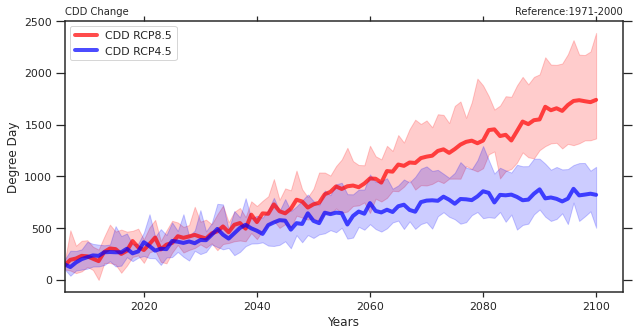

In [3511]:
#Ploting
# plt.rcParams["axes.linewidth"]  = 1.5
# plt.rcParams["axes.spines.right"]  = True
# plt.rcParams["axes.spines.top"]  = True
# plt.rcParams["xtick.major.size"]  = 4
# plt.rcParams["xtick.direction"]  = "out"

fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(np.arange(2006,2101,1),CDD_change_rcp85['MEAN'],color='red', linewidth=4, alpha=0.7,label='CDD RCP8.5')
ax.fill_between(np.arange(2006,2101,1),CDD_change_rcp85['MAX'],CDD_change_rcp85['MIN'], alpha = 0.2, color = 'red')

ax.plot(np.arange(2006,2101,1),CDD_change_rcp45['MEAN'],color='blue', linewidth=4, alpha=0.7,label='CDD RCP4.5')
ax.fill_between(np.arange(2006,2101,1),CDD_change_rcp45['MAX'],CDD_change_rcp45['MIN'], alpha = 0.2, color = 'blue')

ax.set_title('CDD Change  ', loc='left',Fontsize=10)
ax.set_title('Reference:1971-2000',loc='right', fontsize=10)

ax.legend(loc = 'upper left')
# Set the x-axis label
ax.set_xlabel("Years");
# Set the y-axis label
ax.set_ylabel("Degree Day");
plt.xlim(xmin=2006)


plt.savefig('/mys3bucket/cdd_output/Figures/cdd_change.eps', format='eps', dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/cdd_change.png', dpi=500)


In [3512]:
CDD_anomaly_rcp85.head()

CDD_CNRM  CDD_CSIRO  CDD_GFDL  CDD_IPSL  CDD_MIROC5   CDD_MPI  CDD_NorESM1  \
0  1.840541   1.444546  1.658859  2.001374    1.149683  1.960098     1.228730   
1  1.158888   1.524201  5.491020  2.817628    1.023371  1.646649     1.834966   
2  2.403906   3.002900  0.739696  3.774967    1.768974  2.367474     2.470223   
3  0.929083   2.106752  2.257417  4.328824    2.947229  2.826940     3.199240   
4  1.997296   2.009273  2.367492  1.432014    3.844470  2.170397     4.391258   

       MEAN       MIN       MAX  
0  1.611976  1.149683  2.001374  
1  2.213818  1.023371  5.491020  
2  2.361163  0.739696  3.774967  
3  2.656498  0.929083  4.328824  
4  2.601743  1.432014  4.391258

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript bac

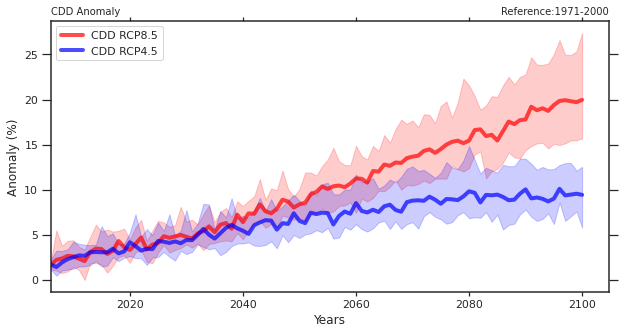

In [3513]:
#Ploting
plt.rcParams["axes.linewidth"]  = 1.5
# plt.rcParams["axes.spines.right"]  = True
# plt.rcParams["axes.spines.top"]  = True
plt.rcParams["xtick.major.size"]  = 4
# plt.rcParams["xtick.direction"]  = "out"
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(np.arange(2006,2101,1),CDD_anomaly_rcp85['MEAN'],color='red', linewidth=4, alpha=0.7,label='CDD RCP8.5')
ax.fill_between(np.arange(2006,2101,1),CDD_anomaly_rcp85['MAX'],CDD_anomaly_rcp85['MIN'], alpha = 0.2, color = 'red')

ax.plot(np.arange(2006,2101,1),CDD_anomaly_rcp45['MEAN'],color='blue', linewidth=4, alpha=0.7,label='CDD RCP4.5')
ax.fill_between(np.arange(2006,2101,1),CDD_anomaly_rcp45['MAX'],CDD_anomaly_rcp45['MIN'], alpha = 0.2, color = 'blue')

ax.set_title('CDD Anomaly  ', loc='left',Fontsize=10)
ax.set_title('Reference:1971-2000',loc='right', fontsize=10)

ax.legend(loc = 'upper left')
# Set the x-axis label
ax.set_xlabel("Years");
# Set the y-axis label
ax.set_ylabel("Anomaly (%)");
plt.xlim(xmin=2006)


plt.savefig('/mys3bucket/cdd_output/Figures/cdd_anomaly.eps', format='eps',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/cdd_anomaly.png',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/cdd_anomaly.svg',dpi=500)

In [3514]:
## Export files 
CDD_anomaly_rcp45.to_csv('/mys3bucket/cdd_output/CDD_anomaly_rcp45.csv')
CDD_anomaly_rcp85.to_csv('/mys3bucket/cdd_output/CDD_anomaly_rcp85.csv')

In [3515]:
## Export files 
CDD_change_rcp85.to_csv('/mys3bucket/cdd_output/CDD_change_rcp85.csv')
CDD_change_rcp45.to_csv('/mys3bucket/cdd_output/CDD_change_rcp45.csv')

In [3516]:
CDD_change_rcp85.tail()

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
90  1300.341773  2315.437409  1691.838585  1930.470621  1524.909637   
91  1421.136206  2175.129011  1318.110372  2147.629515  1688.011631   
92  1346.564755  1997.539300  1491.980191  2171.064219  1854.679698   
93  1358.844987  2185.165228  1548.497774  2205.157219  1495.315658   
94  1372.488031  2385.572281  1365.336383  2120.826914          NaN   

        CDD_MPI  CDD_NorESM1         MEAN          MIN          MAX  
90  1842.854932  1487.467814  1727.617253  1300.341773  2315.437409  
91  1938.602662  1456.948641  1735.081148  1318.110372  2175.129011  
92  1829.660414  1383.586426  1725.010715  1346.564755  2171.064219  
93  1871.374731  1347.751220  1716.015260  1347.751220  2205.157219  
94  1771.031975  1415.115791  1738.395229  1365.336383  2385.572281

## Task 0- Historical CDD of uncorrected Model

In [3518]:
from glob import glob
# ds = xr.merge([xr.open_dataset(f) for f in glob('/mys3bucket/Historical_cdd/MMM_CDD_tas_*.nc')])

In [3519]:
glob('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_*.nc')

['/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CNRM-CM5_1971_2000_WAfrik.nc',
 '/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CSIRO-Mk3-6-0_1971_2000_WAfrik.nc',
 '/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_GFDL-ESM2M__1971_2000_WAfrik.nc',
 '/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_IPSL-CM5A-MR_1971_2000_WAfrik.nc',
 '/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MIROC5_1971_2000_WAfrik.nc',
 '/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MPI-ESM-LR_1971_2000_WAfrik.nc',
 '/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_NorESM1-M_1971_2000_WAfrik.nc']

In [3521]:
obs=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_Daily_air_temperature_at_2_metres_1971_2000_WA.nc')
mm_model=xr.open_dataset('/mys3bucket/cdd_output/CDD/test/CLIM_MMM_CDD_tas_day_BCSD_historical_r1i1p1_1971_2000.nc')

In [3522]:
Cnrm=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CNRM-CM5_1971_2000_WAfrik.nc')
csiro=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CSIRO-Mk3-6-0_1971_2000_WAfrik.nc')
gfdl=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_GFDL-ESM2M__1971_2000_WAfrik.nc')
ipsl=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_IPSL-CM5A-MR_1971_2000_WAfrik.nc')
miroc=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MIROC5_1971_2000_WAfrik.nc')
mpi=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MPI-ESM-LR_1971_2000_WAfrik.nc')
nor=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_NorESM1-M_1971_2000_WAfrik.nc')

In [3523]:
all_base=obs.rename({'cooling_degree_days':'CDD_OBS'})

In [3524]:
all_base['CDD_MME']=mm_model.cooling_degree_days.mean('time')
all_base['CDD_CNRM']=Cnrm.cooling_degree_days.mean('time')
all_base['CDD_CSIRO']=csiro.cooling_degree_days.mean('time')
all_base['CDD_GFDL']=gfdl.cooling_degree_days.mean('time')
all_base['CDD_IPSL']=ipsl.cooling_degree_days.mean('time')
all_base['CDD_MIROC5']=miroc.cooling_degree_days.mean('time')
all_base['CDD_MPI']=mpi.cooling_degree_days.mean('time')
all_base['CDD_NorESM1']=nor.cooling_degree_days.mean('time')

In [3525]:
all_base_masked=all_base.where(mask)

In [3526]:
longitude=all_base.CDD_OBS.lon.values 
latitude=all_base.CDD_OBS.lat.values 

In [3527]:
order_plot=['CDD_OBS','CDD_MME','CDD_CNRM','CDD_CSIRO','CDD_GFDL','CDD_IPSL','CDD_MIROC5','CDD_MPI','CDD_NorESM1']

In [3528]:
# Libraries below are essential to perform statistical metrics

In [3529]:
import metpy.calc as mpcalc
from metpy.units import units
import xskillscore as xs

In [3530]:
all_base_masked

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
Data variables:
    CDD_OBS      (lat, lon) float32 nan nan nan nan ... 169.8 133.2 131.4 134.9
    CDD_MME      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CNRM     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CSIRO    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_GFDL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_IPSL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MIROC5   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MPI      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_NorESM1  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

## Climatological mean CDD per model

<function matplotlib.pyplot.show>

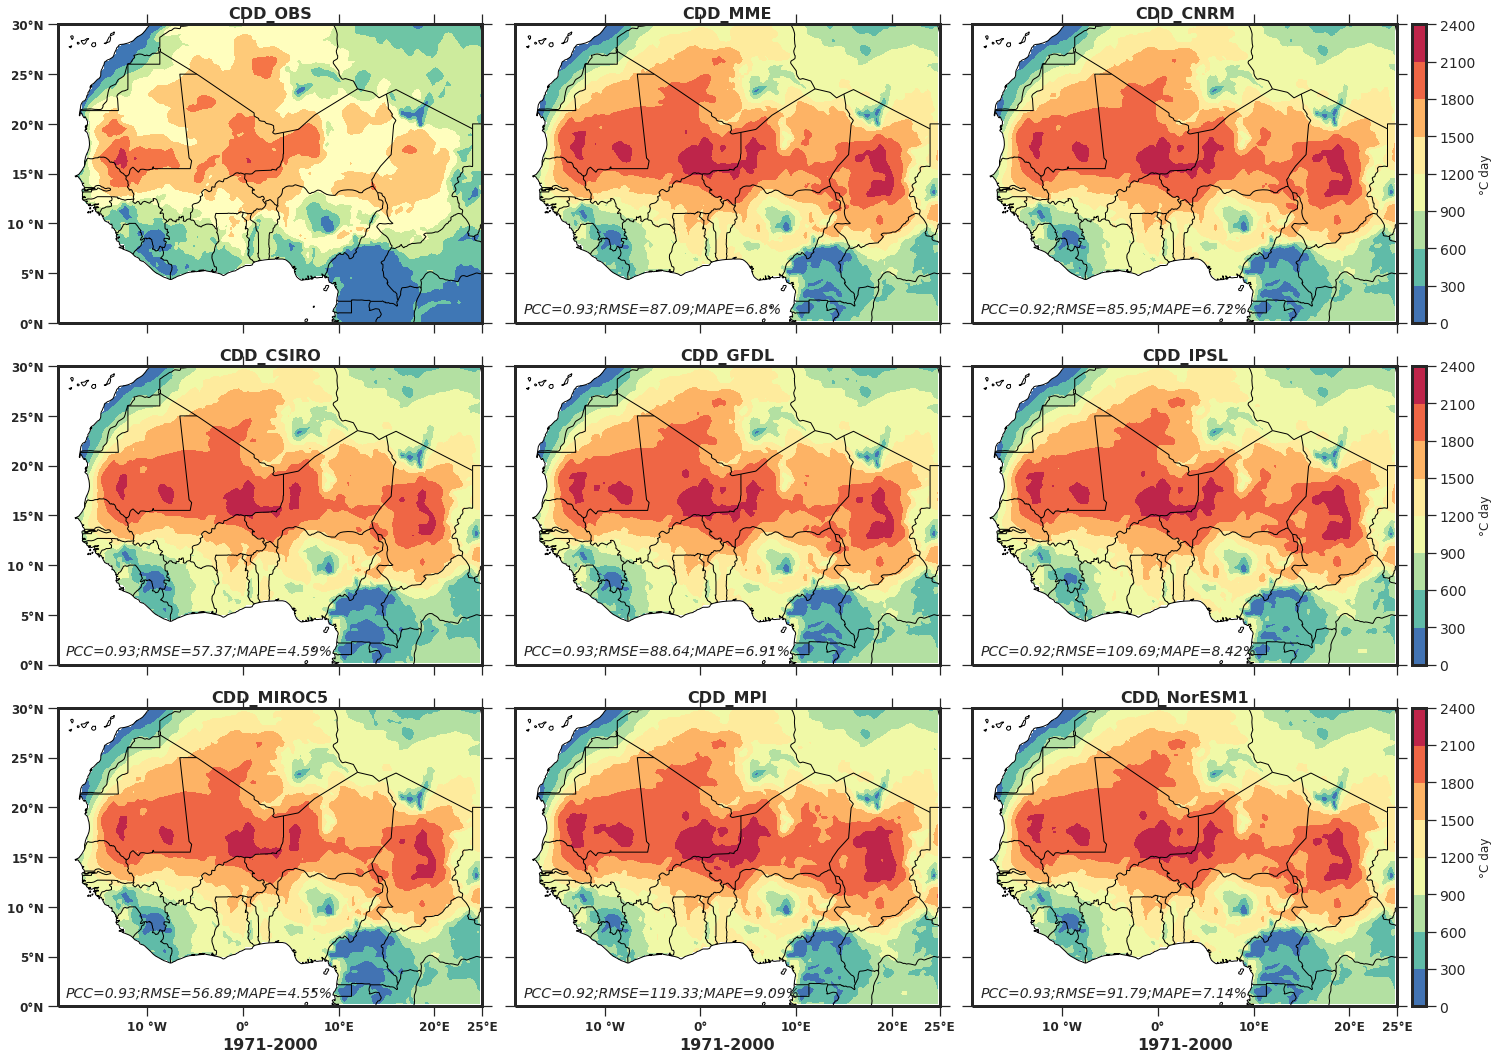

In [3531]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =16
plt.rcParams["axes.linewidth"]  = 3
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=10
plt.rcParams["ytick.major.size"]=10
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(3,3,sharex=True, sharey=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,15)

for i in range(3):
    
    o= axes[0,i].contourf(longitude, latitude,all_base_masked[str(order_plot[i])],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,all_base_masked[str(order_plot[i+3])],
                          transform=projection,cmap='Spectral_r')
    
    q= axes[2,i].contourf(longitude, latitude,all_base_masked[str(order_plot[i+6])],
                          transform=projection,cmap='Spectral_r')
    
    axes[0, i].set_title(order_plot[i],fontsize=16,fontweight='bold')
    axes[1, i].set_title(order_plot[i+3],fontsize=16,fontweight='bold')
    axes[2, i].set_title(order_plot[i+6],fontsize=16,fontweight='bold')
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
#     ax.axes.axis('tight')

for i,model in enumerate(('CDD_MME','CDD_CNRM')):
    axes[0,i+1].text(-18.5,1,
             str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
                 str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';MAPE='+
                 str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),
                                   all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
             fontsize=14, ha='left',fontstyle='italic')

for i,model in enumerate(('CDD_CSIRO','CDD_GFDL','CDD_IPSL')):
    axes[1,i].text(-18.5,1,
             str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
                 str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';MAPE='+
                 str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
             fontsize=14, ha='left',fontstyle='italic')

for i,model in enumerate(('CDD_MIROC5','CDD_MPI','CDD_NorESM1')):
    axes[2,i].text(-18.5,1,
             str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
                 str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';MAPE='+
                 str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
             fontsize=14, ha='left',fontstyle='italic')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.axes.axis('tight')
    
    
    

for ax in axes[-1,:].flatten():
    ax.set_xlabel('1971-2000',fontsize=16,fontweight='bold')

plt.tight_layout()

# flatten axes and get subplots positions
DP = axes.T.flatten()

# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[6].get_position().x1+0.01,DP[6].get_position().y0,
                 0.01,DP[6].get_position().height])
cax2=fig.add_axes([DP[7].get_position().x1+0.01,DP[7].get_position().y0,
                 0.01,DP[7].get_position().height])
cax3=fig.add_axes([DP[8].get_position().x1+0.01,DP[8].get_position().y0,
                 0.01,DP[8].get_position().height])


# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='\N{DEGREE SIGN}C day')

cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)


plt.savefig('/mys3bucket/cdd_output/Figures/CDD_HIST.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_HIST.png',dpi=300)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_HIST.svg',transparent=True,dpi=500)



plt.show

In [3532]:
# help(cax1.axes.tick_params)

In [3533]:
all_base_masked.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/CDD_finalhist_model.csv')
all_base_masked.to_dataframe().describe()

CDD_OBS       CDD_MME      CDD_CNRM     CDD_CSIRO      CDD_GFDL  \
count  17205.000000  16884.000000  16884.000000  16884.000000  16884.000000   
mean    1193.433716   1280.529175   1279.385986   1250.805420   1282.073975   
std      577.086121    528.176880    525.573120    529.335327    530.015686   
min        0.000000      0.009627      0.000000      0.000000      0.000000   
25%      770.413391    896.607666    898.304443    868.283813    895.704468   
50%     1246.676147   1283.044434   1282.122070   1254.613281   1285.781860   
75%     1657.061401   1741.354492   1740.028931   1714.412598   1736.714722   
max     2565.156982   2300.126221   2296.571045   2273.693359   2299.077148   

           CDD_IPSL    CDD_MIROC5       CDD_MPI   CDD_NorESM1  
count  16884.000000  16884.000000  16884.000000  16884.000000  
mean    1303.120728   1250.320557   1312.767944   1285.225952  
std      518.875427    529.061523    533.488892    531.913696  
min        0.000000      0.000000      0.000000      0.000000  
25%      922.783142    869.749146    923.021484    897.325806  
50%     1307.137695   1254.600098   1311.606323   1289.428467  
75%     1758.121216   1712.769043   1781.373901   1745.988770  
max     2302.813232   2270.025146   2344.805664   2313.897705

In [3253]:
all_base_masked

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
Data variables:
    CDD_OBS      (lat, lon) float32 nan nan nan nan ... 169.8 133.2 131.4 134.9
    CDD_MME      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CNRM     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CSIRO    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_GFDL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_IPSL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MIROC5   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MPI      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_NorESM1  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

# Task 2- Changes of Observed CDD OVER GWL 

In [3534]:
# Cnrm_df=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CNRM-CM5_1971_2000_WAfrik.nc')
# csiro_df=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CSIRO-Mk3-6-0_1971_2000_WAfrik.nc')
# gfdl_df=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_GFDL-ESM2M__1971_2000_WAfrik.nc')
# ipsl=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_IPSL-CM5A-MR_1971_2000_WAfrik.nc')
# miroc=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MIROC5_1971_2000_WAfrik.nc')
# mpi=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MPI-ESM-LR_1971_2000_WAfrik.nc')
# nor=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_NorESM1-M_1971_2000_WAfrik.nc')

In [3535]:
mm_model=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_MMM_CDD_tas_day_BCSD_historical_r1i1p1_1971_2000.nc')

In [3537]:
cdd_gwl_model=xr.open_mfdataset('CDD_GWL_*_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc')

In [3538]:
cdd_model=xr.open_dataset('CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc').mean('time')

In [3539]:
cdd_final=cdd_model

In [3540]:
cdd_final

<xarray.Dataset>
Dimensions:              (lat: 121, lon: 181)
Coordinates:
  * lon                  (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                  (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    cooling_degree_days  (lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [3541]:
all=glob('CDD_GWL_*.nc')

In [3542]:
all

['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2018_2047_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2020_2049_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2002_2031_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MIROC5_2019_2048_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MPI-ESM-LR_2004_2033_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_NorESM1-M_2019_2048_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2029_2058_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2030_2059_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2037_2069_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2016_2045_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_MIROC5_2034_2063_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1

In [3543]:
## Combine files together by gwls
GWL_NAME=['1.5','2.0','2.5','3.0'] # Models prefix labels
NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

i=0
for gwl in (GWL_NAME):
    print(gwl)
    for model in (NEX_name):
        model_dt=glob('CDD_GWL_'+gwl+'_tas_BCSD_rcp85_r1i1p1_'+str(model)+'_*.nc')
        print(model_dt)
        if i<=0:
            i=i+1
#             print('1st opening')
            cdd_model=xr.open_dataset(model_dt[0]).mean('time')
            cdd_final=cdd_model.rename({'cooling_degree_days':str('CDD_'+gwl+'_'+model)})
        if i > 0 :
#             print('2nd opening')
#             print(str('CDD_'+model))
            tmp=xr.open_dataset(model_dt[0]).mean('time')
            cdd_final[str('CDD_'+gwl+'_'+model)]=tmp.cooling_degree_days

cdd_final

1.5
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2018_2047_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2020_2049_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2002_2031_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MIROC5_2019_2048_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MPI-ESM-LR_2004_2033_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_NorESM1-M_2019_2048_WAfrik_rg_Bias-eqm.nc']
2.0
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2029_2058_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2030_2059_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2037_2069_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2016_2045_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_MIROC5_2034_2063_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_

<xarray.Dataset>
Dimensions:                (lat: 121, lon: 181)
Coordinates:
  * lon                    (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                    (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    CDD_1.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan

In [3544]:
GWL_NAME=['1.5','2.0','2.5','3.0'] # Models prefix labels
NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

In [3545]:
## Create a masked file
cdd_final=cdd_final.where(mask)

In [3353]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

# Plot CDD by models and global warming level

<function matplotlib.pyplot.show>

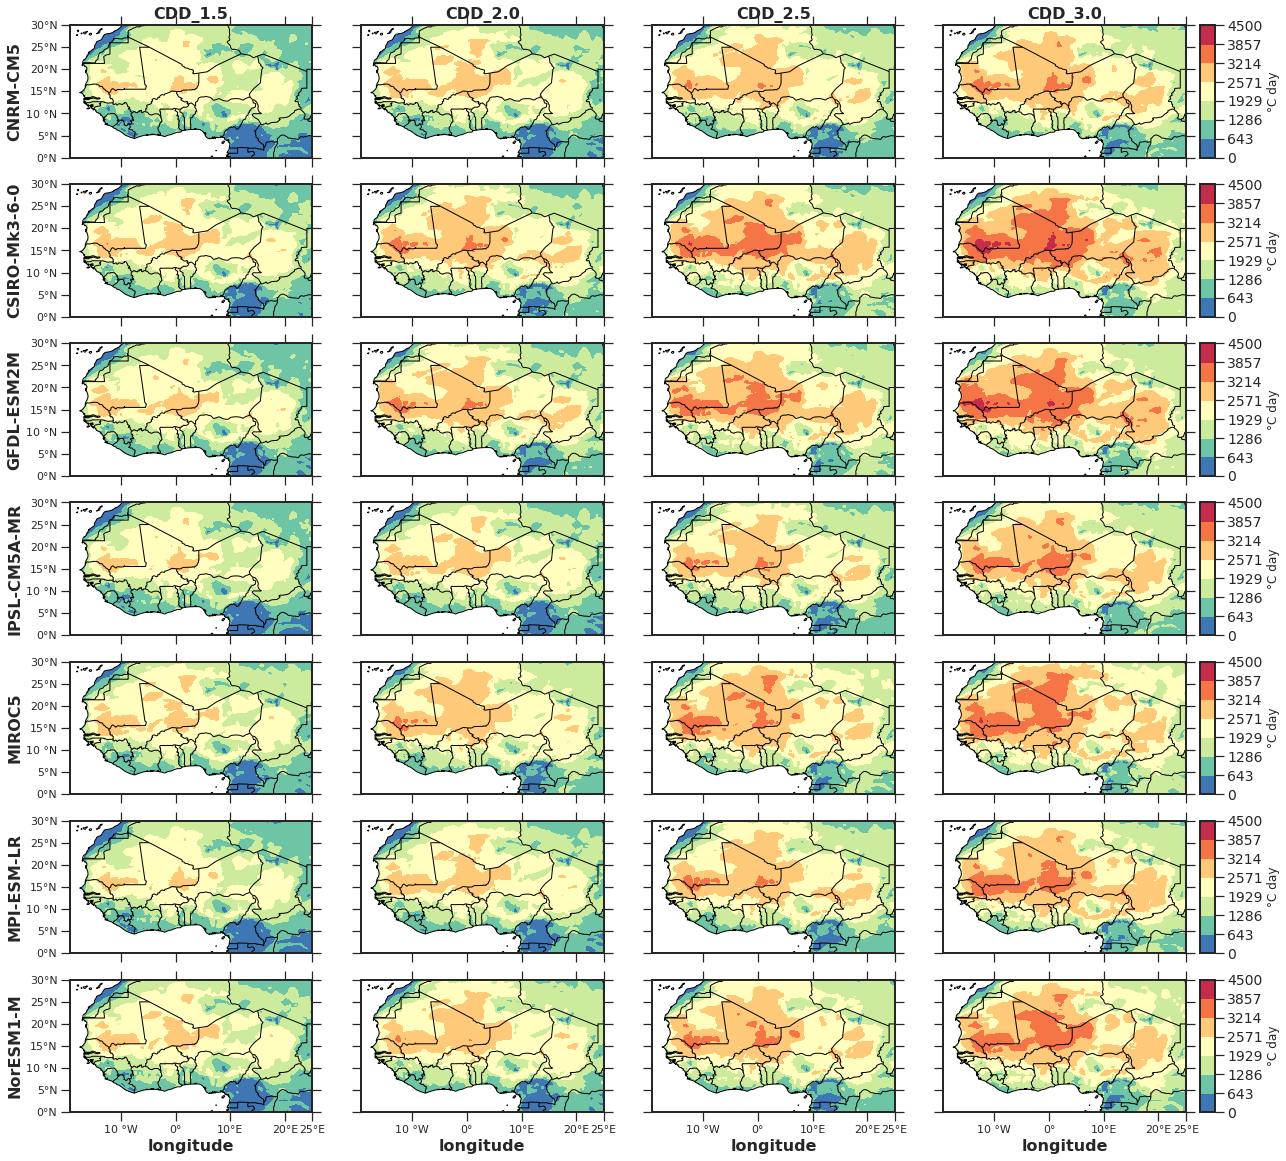

In [3546]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=9
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(7,4,sharex=True, sharey=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,20)
levels = np.linspace(0,4500,8)

# NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

for i, gwl in enumerate(GWL_NAME):
    
    o= axes[0,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_CNRM-CM5')],
                          transform=projection,cmap='Spectral_r',levels=levels)
    p= axes[1,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_CSIRO-Mk3-6-0')],
                          transform=projection,cmap='Spectral_r',levels=levels)
    q= axes[2,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_GFDL-ESM2M')],
                          transform=projection,cmap='Spectral_r',levels=levels)   
    r= axes[3,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_IPSL-CM5A-MR')],
                          transform=projection,cmap='Spectral_r',levels=levels)
    s= axes[4,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_MIROC5')],
                          transform=projection,cmap='Spectral_r',levels=levels) 
    t= axes[5,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_MPI-ESM-LR')],
                          transform=projection,cmap='Spectral_r',levels=levels)
    u= axes[6,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_NorESM1-M')],
                          transform=projection,cmap='Spectral_r',levels=levels) 

    axes[0, i].set_title(str('CDD_'+gwl),fontsize=16,fontweight='bold')

# Assign label to y axis
for i,rowlabel in enumerate(NEX_name):
    axes[i, 0].set_ylabel(rowlabel,fontsize=16,fontweight='bold')
    
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
#     ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')
    
    

for ax in axes[-1,:].flatten():
    ax.set_xlabel('longitude',fontsize=16,fontweight='bold')



# flatten axes and get subplots positions
DP = axes.T.flatten()

# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[21].get_position().x1+0.01,DP[21].get_position().y0,
                 0.01,DP[21].get_position().height])
cax2=fig.add_axes([DP[22].get_position().x1+0.01,DP[22].get_position().y0,
                 0.01,DP[22].get_position().height])
cax3=fig.add_axes([DP[23].get_position().x1+0.01,DP[23].get_position().y0,
                 0.01,DP[23].get_position().height])
cax4=fig.add_axes([DP[24].get_position().x1+0.01,DP[24].get_position().y0,
                 0.01,DP[24].get_position().height])
cax5=fig.add_axes([DP[25].get_position().x1+0.01,DP[25].get_position().y0,
                 0.01,DP[25].get_position().height])
cax6=fig.add_axes([DP[26].get_position().x1+0.01,DP[26].get_position().y0,
                 0.01,DP[26].get_position().height])
cax7=fig.add_axes([DP[27].get_position().x1+0.01,DP[27].get_position().y0,
                 0.01,DP[27].get_position().height])

# plt.tight_layout()

# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='\N{DEGREE SIGN}C day')
fig.colorbar(r, cax=cax4,label='\N{DEGREE SIGN}C day')
fig.colorbar(s, cax=cax5,label='\N{DEGREE SIGN}C day')
fig.colorbar(t, cax=cax6,label='\N{DEGREE SIGN}C day')
fig.colorbar(u, cax=cax7,label='\N{DEGREE SIGN}C day')
# fig.colorbar(vars, cax=cax2,label='C day')

cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)
cax4.axes.tick_params(labelsize=14)
cax5.axes.tick_params(labelsize=14)
cax6.axes.tick_params(labelsize=14)
cax7.axes.tick_params(labelsize=14)






plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl.svg',dpi=300,format='svg')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl.png',transparent=True,dpi=300)



plt.show

In [3547]:
cdd_final.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/CDD_final_gwl_models.csv')
cdd_final.to_dataframe().describe()

CDD_1.5_CNRM-CM5  CDD_1.5_CSIRO-Mk3-6-0  CDD_1.5_GFDL-ESM2M  \
count      16884.000000           16884.000000        16884.000000   
mean        1541.539247            1726.620134         1667.288164   
std          636.270257             656.462947          650.551703   
min            0.102085               0.032071            0.244249   
25%         1084.363174            1237.082124         1157.434961   
50%         1618.618572            1798.015458         1735.422653   
75%         2045.438080            2255.620168         2202.862434   
max         2982.954885            3229.834184         3140.015144   

       CDD_1.5_IPSL-CM5A-MR  CDD_1.5_MIROC5  CDD_1.5_MPI-ESM-LR  \
count          16884.000000    16884.000000        16884.000000   
mean            1548.576187     1724.374785         1541.753484   
std              644.205713      630.827364          647.216274   
min                0.045577        0.204296            0.000000   
25%             1096.057893     1282.503328         1068.051057   
50%             1613.028912     1797.113174         1612.829614   
75%             2048.093390     2207.699915         2063.170633   
max             3011.065721     3159.029884         2951.332479   

       CDD_1.5_NorESM1-M  CDD_2.0_CNRM-CM5  CDD_2.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         1653.022143       1732.770929            1968.131742   
std           656.105839        670.845647             713.199008   
min             0.152093          0.365182               0.224459   
25%          1207.205899       1250.045886            1414.301746   
50%          1727.028591       1810.630676            2036.332300   
75%          2156.941317       2262.832118            2551.194456   
max          3086.773103       3202.266256            3575.224018   

       CDD_2.0_GFDL-ESM2M  ...  CDD_2.5_MIROC5  CDD_2.5_MPI-ESM-LR  \
count        16884.000000  ...    16884.000000        16884.000000   
mean          1951.236141  ...     2183.754362         1973.208733   
std            699.418857  ...      693.495261          707.952217   
min              0.862600  ...        0.786924            0.051100   
25%           1390.500614  ...     1695.264189         1453.549347   
50%           2012.088804  ...     2253.885186         2059.626490   
75%           2534.980142  ...     2711.589168         2539.102469   
max           3527.700374  ...     3705.338276         3511.098194   

       CDD_2.5_NorESM1-M  CDD_3.0_CNRM-CM5  CDD_3.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         2074.092576       2076.735264            2432.852678   
std           703.772491        701.059275             797.120679   
min             2.403149          1.984214               0.536309   
25%          1597.033316       1571.628850            1792.243714   
50%          2153.419911       2159.552451            2498.109401   
75%          2607.286620       2634.219507            3083.695966   
max          3540.510532       3555.616118            4210.309329   

       CDD_3.0_GFDL-ESM2M  CDD_3.0_IPSL-CM5A-MR  CDD_3.0_MIROC5  \
count        16884.000000          16884.000000    16884.000000   
mean          2402.229084           2128.192126     2353.331838   
std            763.730120            721.402650      711.568287   
min             11.437411              0.427497        2.085948   
25%           1769.279686           1569.779920     1862.926627   
50%           2448.167728           2197.823786     2410.595595   
75%           3029.302807           2692.049931     2895.422945   
max           4100.421406           3695.216030     3911.503576   

       CDD_3.0_MPI-ESM-LR  CDD_3.0_NorESM1-M  
count        16884.000000       16884.000000  
mean          2205.786455        2264.539325  
std            748.185308         722.831830  
min              0.136435           5.684233  
25%           1650.400723        1762.050790  
50%        

In [3548]:
## check summary of files

In [3549]:
cdd_final.to_dataframe().describe(percentiles=[.1, .25, .5, .75, .9,.95])

CDD_1.5_CNRM-CM5  CDD_1.5_CSIRO-Mk3-6-0  CDD_1.5_GFDL-ESM2M  \
count      16884.000000           16884.000000        16884.000000   
mean        1541.539247            1726.620134         1667.288164   
std          636.270257             656.462947          650.551703   
min            0.102085               0.032071            0.244249   
10%          627.374225             829.687112          795.982350   
25%         1084.363174            1237.082124         1157.434961   
50%         1618.618572            1798.015458         1735.422653   
75%         2045.438080            2255.620168         2202.862434   
90%         2324.910554            2540.414338         2474.630941   
95%         2464.288675            2671.119487         2613.546187   
max         2982.954885            3229.834184         3140.015144   

       CDD_1.5_IPSL-CM5A-MR  CDD_1.5_MIROC5  CDD_1.5_MPI-ESM-LR  \
count          16884.000000    16884.000000        16884.000000   
mean            1548.576187     1724.374785         1541.753484   
std              644.205713      630.827364          647.216274   
min                0.045577        0.204296            0.000000   
10%              632.508458      830.543626          616.005780   
25%             1096.057893     1282.503328         1068.051057   
50%             1613.028912     1797.113174         1612.829614   
75%             2048.093390     2207.699915         2063.170633   
90%             2364.268683     2516.416368         2348.106135   
95%             2506.988535     2631.726347         2476.966509   
max             3011.065721     3159.029884         2951.332479   

       CDD_1.5_NorESM1-M  CDD_2.0_CNRM-CM5  CDD_2.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         1653.022143       1732.770929            1968.131742   
std           656.105839        670.845647             713.199008   
min             0.152093          0.365182               0.224459   
10%           698.434559        785.163805            1023.376602   
25%          1207.205899       1250.045886            1414.301746   
50%          1727.028591       1810.630676            2036.332300   
75%          2156.941317       2262.832118            2551.194456   
90%          2473.349376       2564.384874            2867.828697   
95%          2611.873221       2702.116602            3007.142095   
max          3086.773103       3202.266256            3575.224018   

       CDD_2.0_GFDL-ESM2M  ...  CDD_2.5_MIROC5  CDD_2.5_MPI-ESM-LR  \
count        16884.000000  ...    16884.000000        16884.000000   
mean          1951.236141  ...     2183.754362         1973.208733   
std            699.418857  ...      693.495261          707.952217   
min              0.862600  ...        0.786924            0.051100   
10%           1044.201614  ...     1235.514960          988.908155   
25%           1390.500614  ...     1695.264189         1453.549347   
50%           2012.088804  ...     2253.885186         2059.626490   
75%           2534.980142  ...     2711.589168         2539.102469   
90%           2834.290840  ...     3079.957728         2846.086558   
95%           2978.476553  ...     3199.871434         2983.632791   
max           3527.700374  ...     3705.338276         3511.098194   

       CDD_2.5_NorESM1-M  CDD_3.0_CNRM-CM5  CDD_3.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         2074.092576       2076.735264            2432.852678   
std           703.772491        701.059275             797.120679   
min             2.403149          1.984214               0.536309   
10%          1084.864268       1112.916257            1399.265800   
25%          1597.033316       1571.628850            1792.243714   
50%          2153.419911       2159.552451            2498.109401   
75%          2607.286620       2634.219507            3083.695966   
90%          2966.640531       2944.406678            3459.488078   
9

In [3550]:
### Compute CDD Change

In [3551]:
obs_clim=xr.open_dataset('/mys3bucket/cdd_output/CDD/CLIM_CDD_Daily_air_temperature_at_2_metres_1970_2000_WA.nc').cooling_degree_days
obs_clim=obs_clim.where(mask)

In [3552]:
cdd_change=cdd_final-obs_clim

In [3553]:
cdd_change

<xarray.Dataset>
Dimensions:                (lat: 121, lon: 181)
Coordinates:
  * lon                    (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                    (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    CDD_1.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan

In [3554]:
# MME_CDD

## Plot CDD change per Global warming change per model

<function matplotlib.pyplot.show>

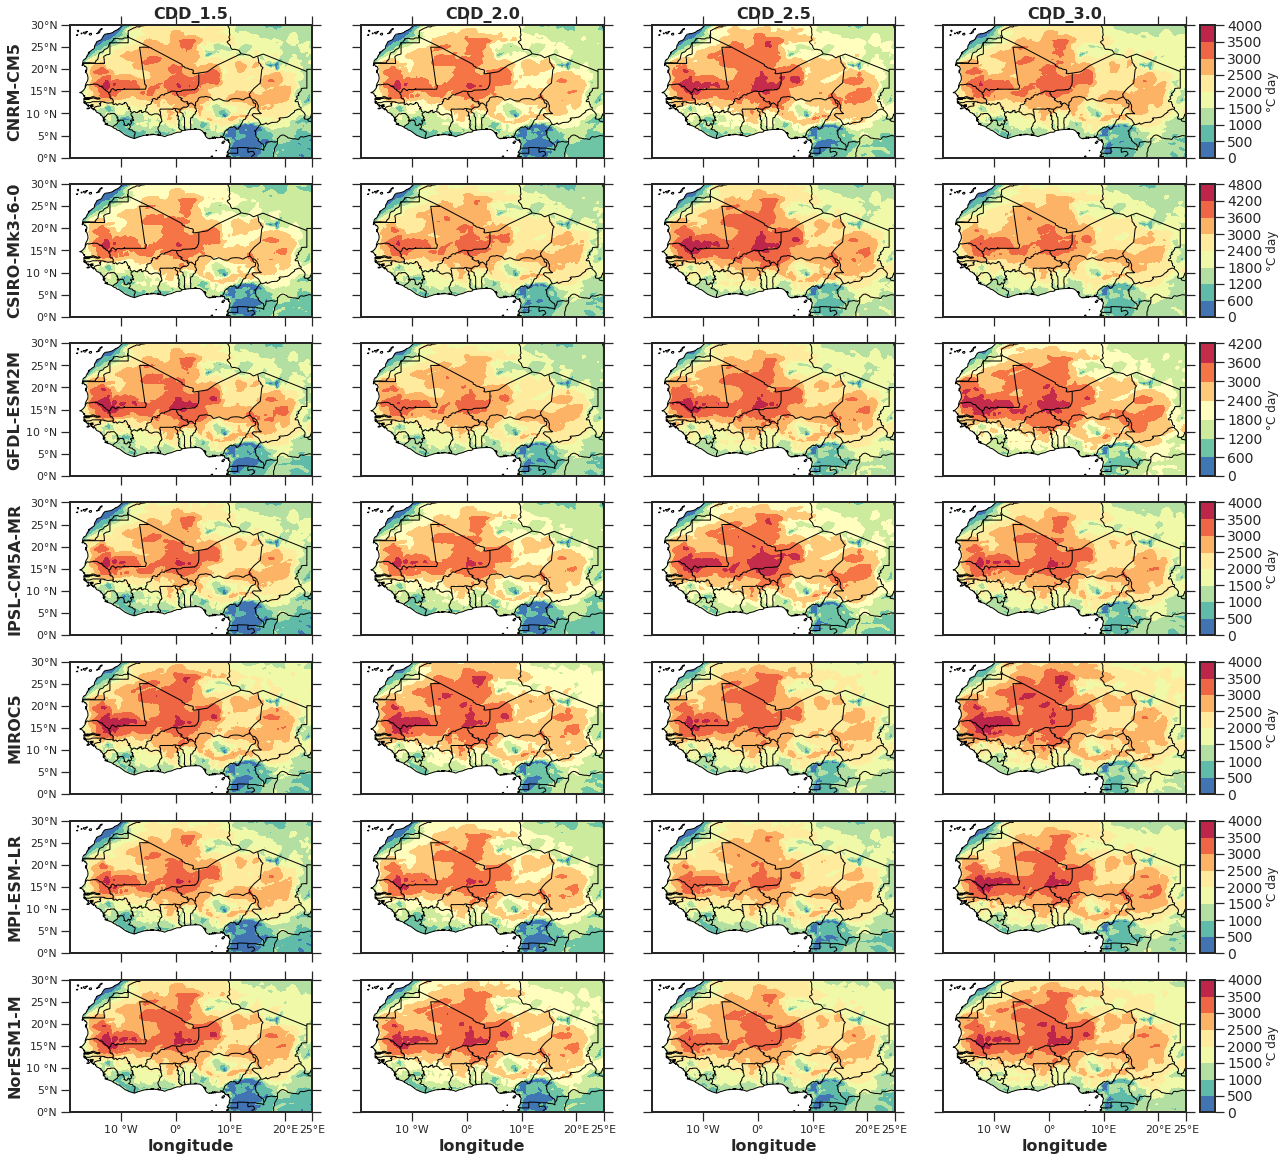

In [3555]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=9
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(7,4,sharex=True, sharey=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,20)

# NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

for i, gwl in enumerate(GWL_NAME):
    
    o= axes[0,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_CNRM-CM5')],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_CSIRO-Mk3-6-0')],
                          transform=projection,cmap='Spectral_r')
    q= axes[2,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_GFDL-ESM2M')],
                          transform=projection,cmap='Spectral_r')   
    r= axes[3,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_IPSL-CM5A-MR')],
                          transform=projection,cmap='Spectral_r')
    s= axes[4,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_MIROC5')],
                          transform=projection,cmap='Spectral_r') 
    t= axes[5,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_MPI-ESM-LR')],
                          transform=projection,cmap='Spectral_r')
    u= axes[6,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_NorESM1-M')],
                          transform=projection,cmap='Spectral_r') 

    axes[0, i].set_title(str('CDD_'+gwl),fontsize=16,fontweight='bold')

# Assign label to y axis
for i,rowlabel in enumerate(NEX_name):
    axes[i, 0].set_ylabel(rowlabel,fontsize=16,fontweight='bold')
    
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
#     ax.axes.axis('tight')

# for i,model in enumerate(('CDD_MME','CDD_CNRM')):
#     axes[0,i+1].text(-18.5,1,
#              str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
#                  str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';RBIAS='+
#                  str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
#              fontsize=14, ha='left',fontstyle='italic')

# for i,model in enumerate(('CDD_CSIRO','CDD_GFDL','CDD_IPSL')):
#     axes[1,i].text(-18.5,1,
#              str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
#                  str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';RBIAS='+
#                  str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
#              fontsize=14, ha='left',fontstyle='italic')

# for i,model in enumerate(('CDD_MIROC5','CDD_MPI','CDD_NorESM1')):
#     axes[2,i].text(-18.5,1,
#              str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
#                  str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';RBIAS='+
#                  str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
#              fontsize=14, ha='left',fontstyle='italic')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')
    
    

for ax in axes[-1,:].flatten():
    ax.set_xlabel('longitude',fontsize=16,fontweight='bold')



# flatten axes and get subplots positions
DP = axes.T.flatten()

# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[21].get_position().x1+0.01,DP[21].get_position().y0,
                 0.01,DP[21].get_position().height])
cax2=fig.add_axes([DP[22].get_position().x1+0.01,DP[22].get_position().y0,
                 0.01,DP[22].get_position().height])
cax3=fig.add_axes([DP[23].get_position().x1+0.01,DP[23].get_position().y0,
                 0.01,DP[23].get_position().height])
cax4=fig.add_axes([DP[24].get_position().x1+0.01,DP[24].get_position().y0,
                 0.01,DP[24].get_position().height])
cax5=fig.add_axes([DP[25].get_position().x1+0.01,DP[25].get_position().y0,
                 0.01,DP[25].get_position().height])
cax6=fig.add_axes([DP[26].get_position().x1+0.01,DP[26].get_position().y0,
                 0.01,DP[26].get_position().height])
cax7=fig.add_axes([DP[27].get_position().x1+0.01,DP[27].get_position().y0,
                 0.01,DP[27].get_position().height])

# plt.tight_layout()

# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='\N{DEGREE SIGN}C day')
fig.colorbar(r, cax=cax4,label='\N{DEGREE SIGN}C day')
fig.colorbar(s, cax=cax5,label='\N{DEGREE SIGN}C day')
fig.colorbar(t, cax=cax6,label='\N{DEGREE SIGN}C day')
fig.colorbar(u, cax=cax7,label='\N{DEGREE SIGN}C day')
cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)
cax4.axes.tick_params(labelsize=14)
cax5.axes.tick_params(labelsize=14)
cax6.axes.tick_params(labelsize=14)
cax7.axes.tick_params(labelsize=14)




plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change.png',transparent=True,dpi=300)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change.svg',dpi=300)


plt.show

In [3556]:
cdd_change.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/CDD_final_change_gwl_models.csv')
cdd_change.to_dataframe().describe()

CDD_1.5_CNRM-CM5  CDD_1.5_CSIRO-Mk3-6-0  CDD_1.5_GFDL-ESM2M  \
count      16884.000000           16884.000000        16884.000000   
mean        1541.539247            1726.620134         1667.288164   
std          636.270257             656.462947          650.551703   
min            0.102085               0.032071            0.244249   
25%         1084.363174            1237.082124         1157.434961   
50%         1618.618572            1798.015458         1735.422653   
75%         2045.438080            2255.620168         2202.862434   
max         2982.954885            3229.834184         3140.015144   

       CDD_1.5_IPSL-CM5A-MR  CDD_1.5_MIROC5  CDD_1.5_MPI-ESM-LR  \
count          16884.000000    16884.000000        16884.000000   
mean            1548.576187     1724.374785         1541.753484   
std              644.205713      630.827364          647.216274   
min                0.045577        0.204296            0.000000   
25%             1096.057893     1282.503328         1068.051057   
50%             1613.028912     1797.113174         1612.829614   
75%             2048.093390     2207.699915         2063.170633   
max             3011.065721     3159.029884         2951.332479   

       CDD_1.5_NorESM1-M  CDD_2.0_CNRM-CM5  CDD_2.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         1653.022143       1732.770929            1968.131742   
std           656.105839        670.845647             713.199008   
min             0.152093          0.365182               0.224459   
25%          1207.205899       1250.045886            1414.301746   
50%          1727.028591       1810.630676            2036.332300   
75%          2156.941317       2262.832118            2551.194456   
max          3086.773103       3202.266256            3575.224018   

       CDD_2.0_GFDL-ESM2M  ...  CDD_2.5_MIROC5  CDD_2.5_MPI-ESM-LR  \
count        16884.000000  ...    16884.000000        16884.000000   
mean          1951.236141  ...     2183.754362         1973.208733   
std            699.418857  ...      693.495261          707.952217   
min              0.862600  ...        0.786924            0.051100   
25%           1390.500614  ...     1695.264189         1453.549347   
50%           2012.088804  ...     2253.885186         2059.626490   
75%           2534.980142  ...     2711.589168         2539.102469   
max           3527.700374  ...     3705.338276         3511.098194   

       CDD_2.5_NorESM1-M  CDD_3.0_CNRM-CM5  CDD_3.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         2074.092576       2076.735264            2432.852678   
std           703.772491        701.059275             797.120679   
min             2.403149          1.984214               0.536309   
25%          1597.033316       1571.628850            1792.243714   
50%          2153.419911       2159.552451            2498.109401   
75%          2607.286620       2634.219507            3083.695966   
max          3540.510532       3555.616118            4210.309329   

       CDD_3.0_GFDL-ESM2M  CDD_3.0_IPSL-CM5A-MR  CDD_3.0_MIROC5  \
count        16884.000000          16884.000000    16884.000000   
mean          2402.229084           2128.192126     2353.331838   
std            763.730120            721.402650      711.568287   
min             11.437411              0.427497        2.085948   
25%           1769.279686           1569.779920     1862.926627   
50%           2448.167728           2197.823786     2410.595595   
75%           3029.302807           2692.049931     2895.422945   
max           4100.421406           3695.216030     3911.503576   

       CDD_3.0_MPI-ESM-LR  CDD_3.0_NorESM1-M  
count        16884.000000       16884.000000  
mean          2205.786455        2264.539325  
std            748.185308         722.831830  
min              0.136435           5.684233  
25%           1650.400723        1762.050790  
50%        

## CDD per GWL with Model ensmean 

In [3557]:
MME_CDD=obs
MME_CDD['MME_1.5']=xr.open_dataset("CLIM_MMM_CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')
MME_CDD['MME_2.0']=xr.open_dataset("CLIM_MMM_CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')
MME_CDD['MME_2.5']=xr.open_dataset("CLIM_MMM_CDD_GWL_2.5_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')
MME_CDD['MME_3.0']=xr.open_dataset("CLIM_MMM_CDD_GWL_3.0_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')

In [3558]:
MME_CDD=MME_CDD.rename({'cooling_degree_days':str('Obs')})

In [3559]:
MME_CDD_bias=MME_CDD-MME_CDD['Obs']

In [3560]:
title=['CDD 1971-2000','CDD MME 1.5','CDD MME 2.0','CDD MME 2.5','CDD MME 3.0']
variables=['Obs','MME_1.5','MME_2.0','MME_2.5','MME_3.0']

In [3561]:
MME_CDD=MME_CDD.where(mask)

In [3562]:
longitude=MME_CDD.lon
latitude=MME_CDD.lat

In [3563]:
MME_CDD_bias=MME_CDD_bias.where(mask)

In [3564]:
import metpy.calc as mpcalc
from metpy.units import units
import xskillscore as xs

In [3565]:
## Mean historical and standard deviation
clim_cdd_mean=MME_CDD_bias['Obs'].mean(['lon','lat']).mean().values # climatology mean
clim_cdd_sd=MME_CDD_bias['Obs'].mean(['lon','lat']).mean().std().values# climatology standard deviation

## Plot - Ensemean of CDD of models per GWLs and Relative change

In [3566]:
MME_CDD_bias

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181)
Coordinates:
  * lon      (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    Obs      (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    MME_1.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [3567]:
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    426.187167    642.878077    862.903569   1063.400399
std        0.0     94.673477    136.345880    175.667625    211.872951
min        0.0      0.169148      0.695934      1.660410      4.296251
25%        0.0    364.429003    551.347729    743.899318    916.497452
50%        0.0    436.997122    658.019359    879.622955   1081.900307
75%        0.0    499.577470    754.378514   1008.167779   1234.390057
max        0.0    623.153027    915.840895   1237.221488   1544.192964

In [3568]:
# MME_CDD_bias.to_dataframe().describe()

In [3569]:
variables 

['Obs', 'MME_1.5', 'MME_2.0', 'MME_2.5', 'MME_3.0']

<function matplotlib.pyplot.show>

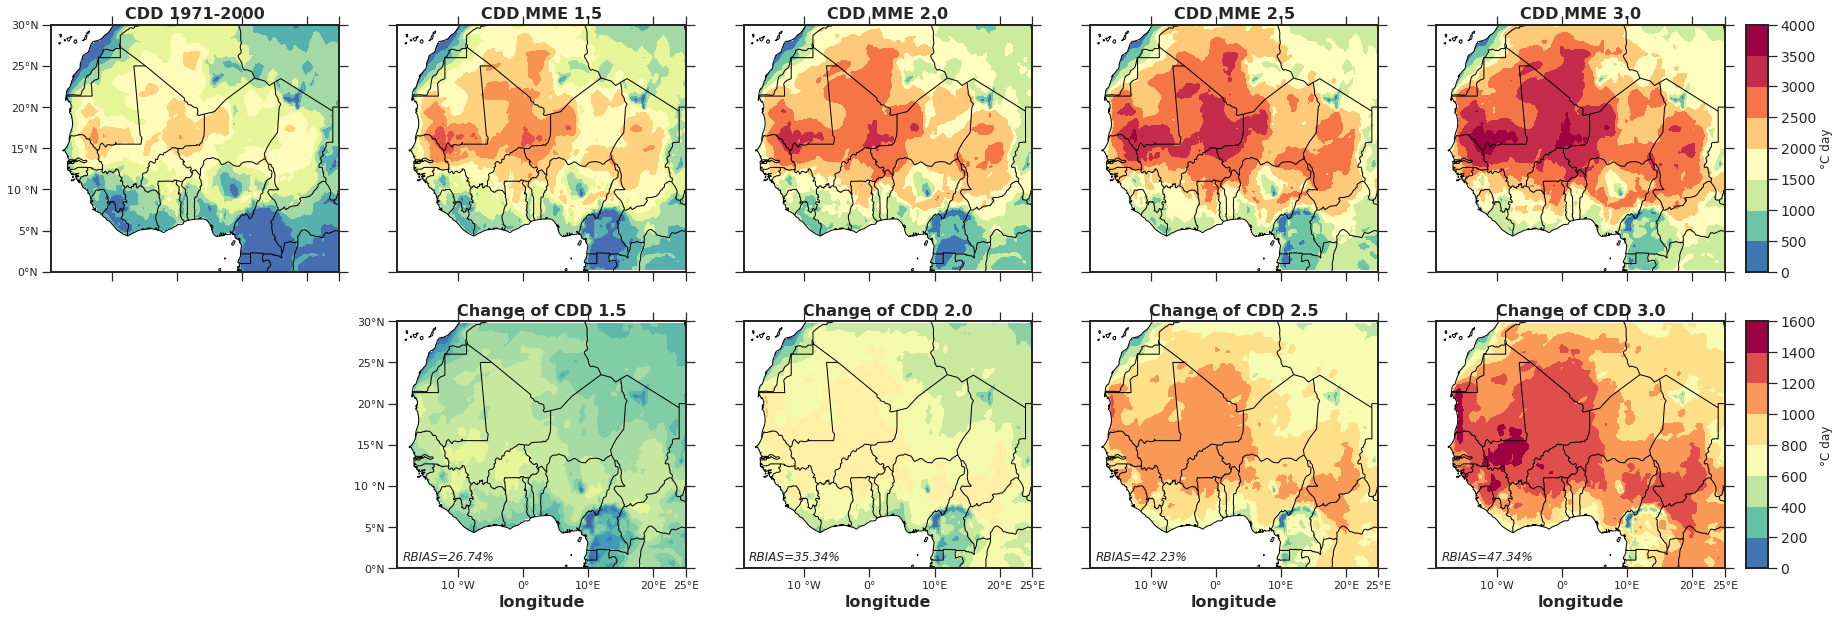

In [3571]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=9
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(2,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(30,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r', vmin=0, vmax=1500)
    
    axes[1,i].text(-18.5,1,
             str('RBIAS='+
                 str(round(xs.mape(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])).values*100,
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
#     MME_CDD_bias
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold')
    
    k=axes[1,:]
    

# fig.colorbar(p,ax=axes[1,:])
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')



    
# Assign label to y axis
# axes[0].set_ylabel('latitude',fontsize=16,fontweight='bold')
  
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')

for ax in axes[-1,:].flatten():
    ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[1,1].yaxis.set_tick_params(which='both', labelleft=True)


# flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[8].get_position().x1+0.01,DP[8].get_position().y0,
                 0.01,DP[8].get_position().height])

cax2=fig.add_axes([DP[9].get_position().x1+0.01,DP[9].get_position().y0,
                 0.01,DP[9].get_position().height])

# plt.tight_layout()
# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)




plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME.svg', format='svg',dpi=300)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME.png',transparent=True,dpi=300)



plt.show

In [3102]:
## CDD PLOT PIVOTED

<function matplotlib.pyplot.show>

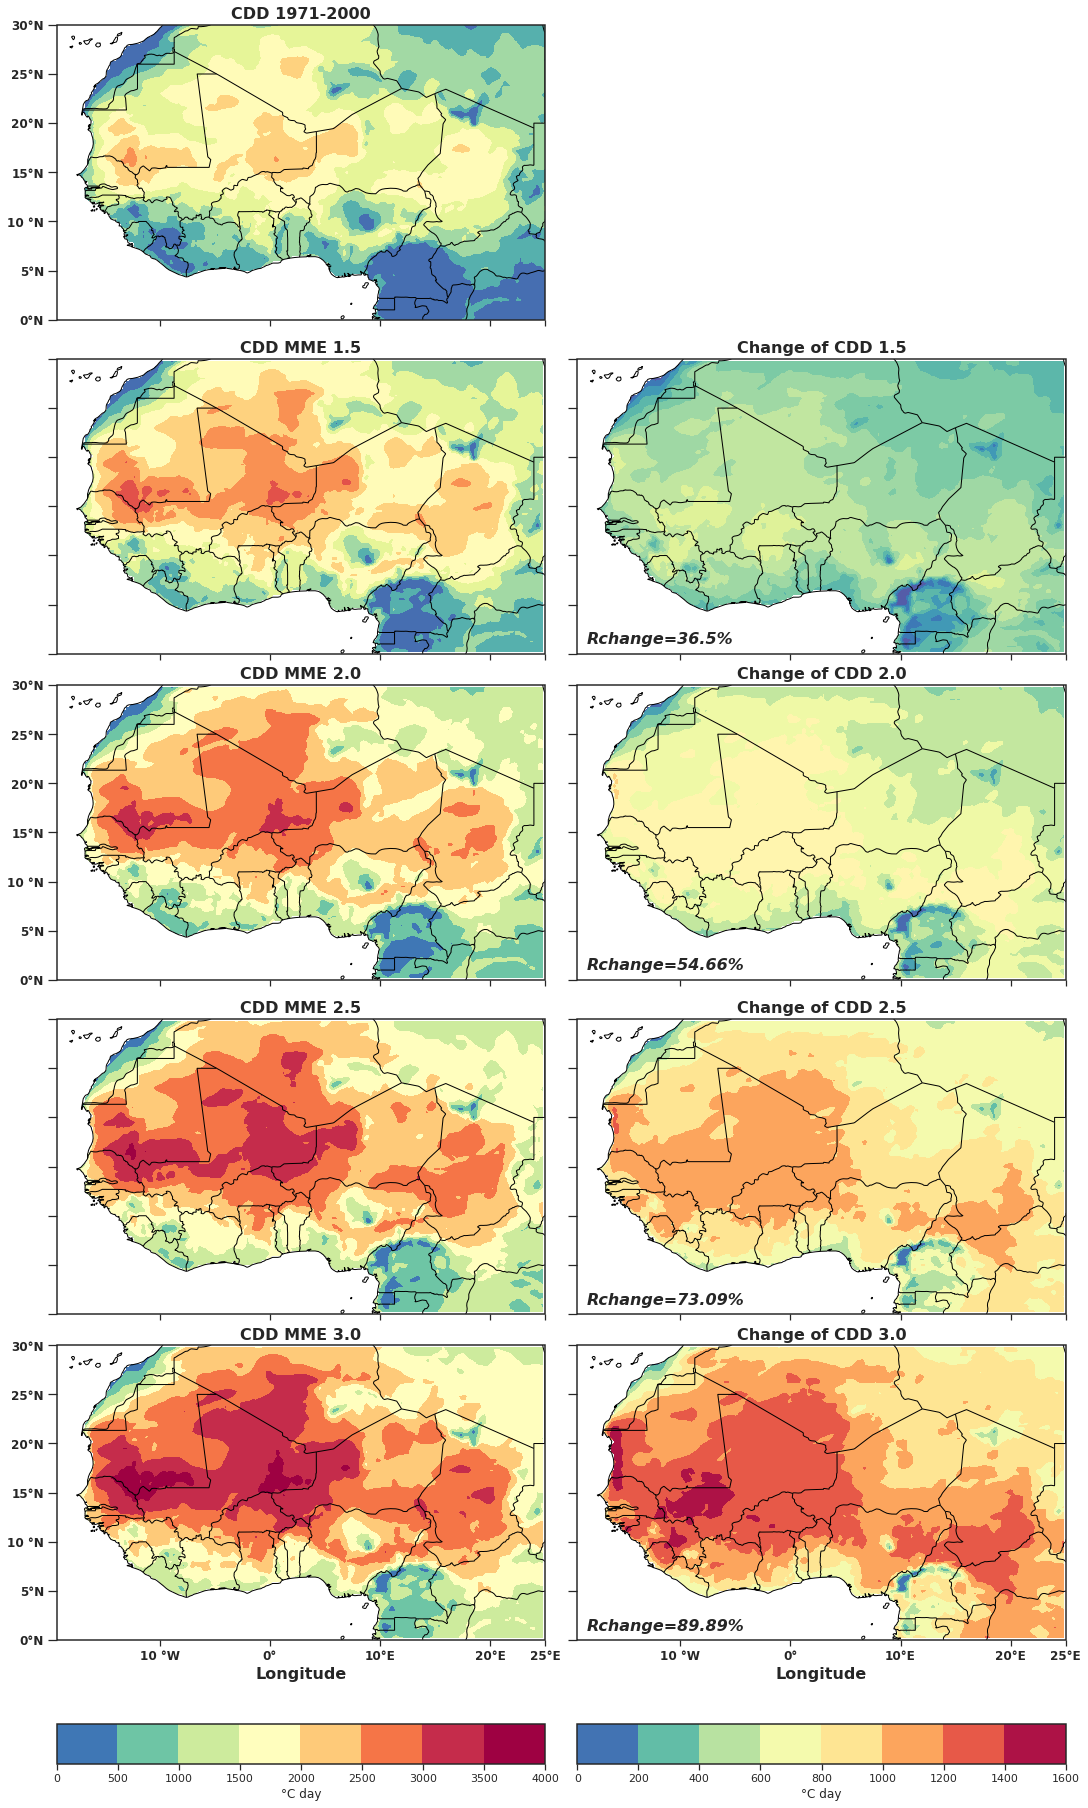

In [3572]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =15
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=6
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =False
plt.rcParams['xtick.top'] =False

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(5,2,subplot_kw=dict(projection=ccrs.PlateCarree()),constrained_layout=True)
fig.set_size_inches(15,25)

for i, gwl in enumerate(variables):
    
    o= axes[i,0].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[i,1].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r',
                         vmin=0, vmax=MME_CDD_bias['MME_3.0'].max().values)
    
    
    
    axes[i,1].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=16, ha='left',fontstyle='italic',fontweight='bold')
    
    MME_CDD_bias
    axes[i,0].set_title(str(title[i]),fontsize=16,fontweight='bold')  
    

axes[0, 1].set_visible(False)
axes[0, 1].set_axis_off()
axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[2, 1].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[3, 1].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[4, 1].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')


axes[1,0].yaxis.set_tick_params(which='both', labelleft=False)
axes[3,0].yaxis.set_tick_params(which='both', labelleft=False)
    
# Assign label to y axis
# axes[0].set_ylabel('latitude',fontsize=16,fontweight='bold')
  
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.axes.axis('tight')

for ax in axes[-1,:].flatten():
    ax.set_xlabel('Longitude',fontsize=16,fontweight='bold')


fig.colorbar(o, ax=axes[:,0], location='bottom',label='\N{DEGREE SIGN}C day')
fig.colorbar(p, ax=axes[:,1], location='bottom',label='\N{DEGREE SIGN}C day')



plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME_T.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME_T.png',transparent=True,dpi=300)
fig.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME_T.svg', format='svg', dpi=500)



plt.show
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

In [3573]:
## Summary of the change

In [3574]:
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    426.187167    642.878077    862.903569   1063.400399
std        0.0     94.673477    136.345880    175.667625    211.872951
min        0.0      0.169148      0.695934      1.660410      4.296251
25%        0.0    364.429003    551.347729    743.899318    916.497452
50%        0.0    436.997122    658.019359    879.622955   1081.900307
75%        0.0    499.577470    754.378514   1008.167779   1234.390057
max        0.0    623.153027    915.840895   1237.221488   1544.192964

In [3576]:
MME_CDD.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/MME_CDD_gwl.csv')
MME_CDD.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.000000  16884.000000  16884.000000  16884.000000  16884.000000
mean    1193.433716   1629.024878   1845.715788   2065.741280   2266.238110
std      577.086121    643.529398    678.286501    707.371721    731.074578
min        0.000000      0.169148      0.695934      1.660410      4.296251
25%      770.413391   1163.654987   1344.858997   1533.094808   1707.695012
50%     1246.676147   1698.194246   1915.725758   2138.573285   2335.192146
75%     1657.061401   2136.451726   2379.274186   2622.802895   2843.302981
max     2565.156982   3080.143628   3349.478469   3610.519316   3858.684569

In [3577]:
MME_CDD_bias.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/MME_CDD_gwL_change.csv')
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    426.187167    642.878077    862.903569   1063.400399
std        0.0     94.673477    136.345880    175.667625    211.872951
min        0.0      0.169148      0.695934      1.660410      4.296251
25%        0.0    364.429003    551.347729    743.899318    916.497452
50%        0.0    436.997122    658.019359    879.622955   1081.900307
75%        0.0    499.577470    754.378514   1008.167779   1234.390057
max        0.0    623.153027    915.840895   1237.221488   1544.192964

### PLot CDD by climatic zone

In [3584]:
MME_CDD_zone=MME_CDD
MME_CDD_zone.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref  int64 0
Data variables:
    Obs          (lat, lon) float32 nan nan nan nan ... 169.8 133.2 131.4 134.9
    MME_1.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [3585]:
all_zone.Climatic_Zone

0      Guinean
0    Soudanian
0     Sahelian
Name: Climatic_Zone, dtype: object

In [3586]:
## CDD by climatic zone
zone_clip=all_zone[all_zone.Climatic_Zone=='Guinean']
clip_guinean =MME_CDD_zone.rio.clip(zone_clip.geometry.apply(mapping),zone_clip.crs, drop=False)

zone_clip=all_zone[all_zone.Climatic_Zone=='Soudanian']
clip_soudanian =MME_CDD_zone.rio.clip(zone_clip.geometry.apply(mapping),zone_clip.crs,drop=False)

zone_clip=all_zone[all_zone.Climatic_Zone=='Sahelian']
clip_sahelian =MME_CDD_zone.rio.clip(zone_clip.geometry.apply(mapping),zone_clip.crs,drop=False)

In [3589]:
clip_guinean.drop('spatial_ref').to_dataframe().describe().to_csv('/mys3bucket/cdd_output/summary_cdd_guinean.csv')
clip_soudanian.drop('spatial_ref').to_dataframe().describe().to_csv('/mys3bucket/cdd_output/summary_cdd_soudanian.csv')
clip_sahelian.drop('spatial_ref').to_dataframe().describe().to_csv('/mys3bucket/cdd_output/summary_cdd_sahelian.csv')

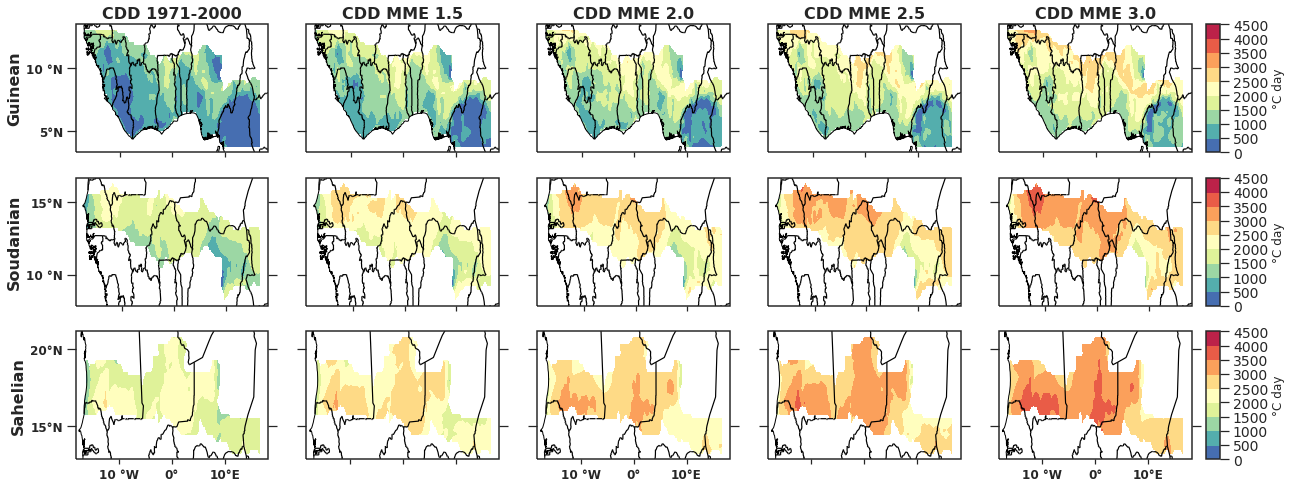

In [3591]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']

longitude=MME_CDD.Obs.lon.values 
latitude=MME_CDD.Obs.lat.values
levels = np.linspace(0,4500,10)

# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(3,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,8)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude,latitude,clip_guinean[str(gwl)],
                          transform=projection,cmap='Spectral_r',levels=levels)
    p= axes[1,i].contourf(longitude,latitude,clip_soudanian[str(gwl)],
                          transform=projection,cmap='Spectral_r',levels=levels)
    q= axes[2,i].contourf(longitude,latitude,clip_sahelian[str(gwl)],
                          transform=projection,cmap='Spectral_r', levels=levels)
    
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
#     axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[0, 0].set_ylabel('Guinean',fontsize=16,fontweight='bold')
axes[1, 0].set_ylabel('Soudanian',fontsize=16,fontweight='bold')
axes[2, 0].set_ylabel('Sahelian',fontsize=16,fontweight='bold')
    
    

axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1.2)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')


 
    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[12].get_position().x1+0.01,DP[12].get_position().y0,
                 0.01,DP[12].get_position().height])

cax2=fig.add_axes([DP[13].get_position().x1+0.01,DP[13].get_position().y0,
                 0.01,DP[13].get_position().height])

cax3=fig.add_axes([DP[14].get_position().x1+0.01,DP[14].get_position().y0,
                 0.01,DP[14].get_position().height])

# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='\N{DEGREE SIGN}C day')
cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)


plt.show
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_zone.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_zone.png',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_zone.svg',dpi=500)


# https://matplotlib.org/3.5.0/gallery/subplots_axes_and_figures/colorbar_placement.html

# Population weighted approach
In this study, the population weighting of degree-days
is achieved by multiplying, for each grid cell, the aver-
aged (over the 30-year period) values of the population
by the averaged degree-day values (ensemble median of
CORDEX simulations). The results, firstly on regular
grids (0.44), are therefore aggregated over macro-regions
(Figure S2) and continents for GWLs from 1.5C to 4C.

Population weighting assures that degree-day averages 
reflect conditions in more densely populated areas of the country. 



The relative changes in population exposure are
estimated by comparing the population exposed at 1.5 C,
2.0 C, and 3.0 C warming levels with that in the reference
period (1986e2005). Considering the different mitigation and
adaptation challenges raised by the selection of different SSPs,
the low emission scenario RCP2.6 is combined with the sustainability pathway (SSP1), the medium emission scenario
RCP4.5 is combined with the historical trend pathway (SSP2),
and the high emission scenario RCP8.5 is combined with a
growth-oriented world (SSP5) (O’Neill et al., 2014, 2017;
Wen et al., 2019; Wang et al., 2020)

In [3592]:
## Interpolate first
## Population weighted of CDD
## Countries CDDP
# https://pythonrepo.com/repo/ks905383-xagg-python-general-utilities
# https://climateestimate.net/content/example-step3.html

In [3593]:
# os.chdir('/mys3bucket/Historical_cdd/Pop_ssp5/test/') # Setting working directory

In [3594]:
## Set time in netcdf files 
# cdo setdate,2010-01-01 ssp5_total_2010_WA_rg.nc  ssp5_total_2010_WA_rg_set.nc &
# cdo setdate,2020-01-01 ssp5_total_2020_WA_rg.nc  ssp5_total_2020_WA_rg_set.nc &
# cdo setdate,2030-01-01 ssp5_total_2030_WA_rg.nc  ssp5_total_2030_WA_rg_set.nc &
# cdo setdate,2040-01-01 ssp5_total_2040_WA_rg.nc  ssp5_total_2040_WA_rg_set.nc &
# cdo setdate,2050-01-01 ssp5_total_2050_WA_rg.nc  ssp5_total_2050_WA_rg_set.nc &
# cdo setdate,2060-01-01 ssp5_total_2060_WA_rg.nc  ssp5_total_2060_WA_rg_set.nc &
# cdo setdate,2070-01-01 ssp5_total_2070_WA_rg.nc  ssp5_total_2070_WA_rg_set.nc &
# cdo setdate,2080-01-01 ssp5_total_2080_WA_rg.nc  ssp5_total_2080_WA_rg_set.nc &
# cdo setdate,2090-01-01 ssp5_total_2090_WA_rg.nc  ssp5_total_2090_WA_rg_set.nc &
# cdo setdate,2100-01-01 ssp5_total_2100_WA_rg.nc  ssp5_total_2100_WA_rg_set.nc &

In [3595]:
# ## Generate interpolated files in between each year 
# cdo intyear,2011,2012,2013,2014,2015,2016,2017,2018,2019, ssp5_total_2010_WA_rg_set.nc ssp5_total_2020_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2021,2022,2023,2024,2025,2026,2027,2028,2029, ssp5_total_2020_WA_rg_set.nc ssp5_total_2030_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2031,2032,2033,2034,2035,2036,2037,2038,2039, ssp5_total_2030_WA_rg_set.nc ssp5_total_2040_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2041,2042,2043,2044,2045,2046,2047,2048,2049, ssp5_total_2040_WA_rg_set.nc ssp5_total_2050_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2051,2052,2053,2054,2055,2056,2057,2058,2059, ssp5_total_2050_WA_rg_set.nc ssp5_total_2060_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2061,2062,2063,2064,2065,2066,2067,2068,2069, ssp5_total_2060_WA_rg_set.nc ssp5_total_2070_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2071,2072,2073,2074,2075,2076,2077,2078,2079, ssp5_total_2070_WA_rg_set.nc ssp5_total_2080_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2081,2082,2083,2084,2085,2086,2087,2088,2089, ssp5_total_2080_WA_rg_set.nc ssp5_total_2090_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2091,2092,2093,2094,2095,2096,2097,2098,2099, ssp5_total_2090_WA_rg_set.nc ssp5_total_2100_WA_rg_set.nc ssp5_total_set &

## Compute Population gobal warming levels

In [3596]:
MME_CDD

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref  int64 0
Data variables:
    Obs          (lat, lon) float32 nan nan nan nan ... 169.8 133.2 131.4 134.9
    MME_1.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [3597]:
## We assumed population in 2000 as the average of the historical period (1971-2000)

In [3598]:
# import population data
Pop_ssp5=xr.open_dataset('/mys3bucket/Pop_SSP/Pop_ssp5/ssp5_total_2010_WA_rg_set.nc')
## Assign proper time indexes
Pop_ssp5['time']=pd.date_range("2000-01-01", freq="1Y", periods=1)
Pop_ssp5=Pop_ssp5.rename({'Band1':'Pop_Obs'})

In [3599]:
Pop_ssp5['Pop_1.5']=xr.open_dataset('/mys3bucket/Pop_SSP/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_1.5_WA.nc').Band1
Pop_ssp5['Pop_2.0']=xr.open_dataset('/mys3bucket/Pop_SSP/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_2.0_WA.nc').Band1
Pop_ssp5['Pop_2.5']=xr.open_dataset('/mys3bucket/Pop_SSP/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_2.5_WA.nc').Band1
Pop_ssp5['Pop_3.0']=xr.open_dataset('/mys3bucket/Pop_SSP/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_3.0_WA.nc').Band1

In [3600]:
Pop_ssp5=Pop_ssp5.mean('time')

In [3601]:
MME_CDDP=Pop_ssp5
MME_CDDP=MME_CDDP.rename({'Pop_Obs':'CDDP_Obs',
                          'Pop_1.5':'CDDP_1.5',
                          'Pop_2.0':'CDDP_2.0',
                          'Pop_2.5':'CDDP_2.5',
                          'Pop_3.0':'CDDP_3.0'})


## COMPUTE WEIGHTED POPULATION COOLING DEGREE DAYS

In [3602]:
MME_CDDP['CDDP_1.5']=Pop_ssp5['Pop_1.5']*MME_CDD['MME_1.5']
MME_CDDP['CDDP_2.0']=Pop_ssp5['Pop_2.0']*MME_CDD['MME_2.0']
MME_CDDP['CDDP_2.5']=Pop_ssp5['Pop_2.5']*MME_CDD['MME_2.5']
MME_CDDP['CDDP_3.0']=Pop_ssp5['Pop_3.0']*MME_CDD['MME_3.0']
MME_CDDP['CDDP_Obs']=Pop_ssp5['Pop_Obs']*MME_CDD['Obs']

In [3605]:
import geopandas as gpd

In [3606]:
## import west african countries shapefiles

In [3607]:
states_gdf = gpd.read_file('/mys3bucket/ERA_Temp/West_Africa_shapefile/west_africa_shape_new.shp',crs="epsg:4326")
states_gdf.head()

fid iso_a2                  NAME FIPS_10_ ISO_A3 WB_A2 WB_A3  \
0  216.0     TD                  Chad       CD    TCD    TD   TCD   
1  273.0     SL          Sierra Leone       SL    SLE    SL   SLE   
2  274.0     GN                Guinea       GV    GIN    GN   GIN   
3  275.0     CF  Central African Rep.       CT    CAF    CF   CAF   
4  301.0     NG               Nigeria       NI    NGA    NG   NGA   

                                            geometry  
0  POLYGON ((18.17543 8.02195, 18.07045 8.01920, ...  
1  MULTIPOLYGON (((-12.49299 7.56802, -12.50182 7...  
2  POLYGON ((-13.64327 9.54254, -13.72240 9.50580...  
3  POLYGON ((16.42749 2.72649, 16.19666 2.23645, ...  
4  MULTIPOLYGON (((7.27418 4.49189, 7.33253 4.491...

In [3129]:
states_gdf.head()

fid iso_a2                  NAME FIPS_10_ ISO_A3 WB_A2 WB_A3  \
0  216.0     TD                  Chad       CD    TCD    TD   TCD   
1  273.0     SL          Sierra Leone       SL    SLE    SL   SLE   
2  274.0     GN                Guinea       GV    GIN    GN   GIN   
3  275.0     CF  Central African Rep.       CT    CAF    CF   CAF   
4  301.0     NG               Nigeria       NI    NGA    NG   NGA   

                                            geometry  
0  POLYGON ((18.17543 8.02195, 18.07045 8.01920, ...  
1  MULTIPOLYGON (((-12.49299 7.56802, -12.50182 7...  
2  POLYGON ((-13.64327 9.54254, -13.72240 9.50580...  
3  POLYGON ((16.42749 2.72649, 16.19666 2.23645, ...  
4  MULTIPOLYGON (((7.27418 4.49189, 7.33253 4.491...

In [3608]:
# ! pip install rioxarray

In [3609]:
import rioxarray
from shapely.geometry import mapping

In [3611]:
# https://towardsdatascience.com/how-to-use-python-to-obtain-the-temperature-of-any-place-on-earth-b92aae44b831

In [3612]:
Data_temp=MME_CDDP

In [3613]:
# convert into standard CRS 
Data_temp.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref  int64 0
Data variables:
    CDDP_Obs     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_1.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_3.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [3614]:
Data_temp

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref  int64 0
Data variables:
    CDDP_Obs     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_1.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_3.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [3615]:
## Masking data per country vector files and generate variable output

In [3616]:
temp_country = {}
small_countries = []
for i in range(states_gdf.shape[0]):
    data = states_gdf[states_gdf.index==i]
    try:
        clip = Data_temp.rio.clip(data.geometry.apply(mapping), data.crs).mean(dim=['lon','lat'])
        temp_country[states_gdf.iloc[i]['NAME']] = clip
        
    except:
        small_countries.append(states_gdf.iloc[i]['NAME'])

In [3617]:
temp_country

{'Algeria': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 611.4
     CDDP_1.5     float64 915.4
     CDDP_2.0     float64 1.059e+03
     CDDP_2.5     float64 1.152e+03
     CDDP_3.0     float64 1.197e+03, 'Benin': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 4.432e+04
     CDDP_1.5     float64 9.123e+04
     CDDP_2.0     float64 1.26e+05
     CDDP_2.5     float64 1.554e+05
     CDDP_3.0     float64 1.785e+05, 'Burkina Faso': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 7.294e+04
     CDDP_1.5     float64 1.443e+05
     CDDP_2.0     float64 1.953e+05
     CDDP_2.5     float64 2.371e+05
     CDDP_3.0     float64 2.719e+05, 'Cameroon': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 1.711e+04
 

In [3618]:
# small_countries

In [3619]:
dd=pd.DataFrame()
for key in temp_country.keys():
    tmp=temp_country[key]
    tmp2=tmp.expand_dims("Country").to_dataframe().reset_index().drop(columns='spatial_ref')
    tmp2['Country']=str(key)
    
    dd=dd.append(tmp2)

In [3620]:
dd.head()

Country       CDDP_Obs       CDDP_1.5       CDDP_2.0  \
0                  Chad   10304.511719   20286.722798   27636.234942   
0          Sierra Leone   61931.097656  156903.625797  223896.798860   
0                Guinea   20065.341797   41904.815874   52305.518594   
0  Central African Rep.    2940.820312    6931.041370    9559.624789   
0               Nigeria  145859.390625  316821.837648  461933.320458   

        CDDP_2.5       CDDP_3.0  
0   33803.917777   38658.629724  
0  284579.145277  334067.179420  
0   60225.995135   65809.859745  
0   11965.921520   13862.673927  
0  604198.594529  735073.011516

In [3621]:
dd.to_csv('/mys3bucket/cdd_output/summary_cddp_country_new_03_02_2023.csv')

In [3622]:
## Merge datasets

In [3623]:
MME_CDD_bias_new=MME_CDD_bias.rename({'Obs':'Obs_bias',
                                  'MME_1.5':'MME_1.5_bias',
                                  'MME_2.0':'MME_2.0_bias',
                                  'MME_2.5':'MME_2.5_bias',
                                  'MME_3.0':'MME_3.0_bias'})

In [3624]:
all_files=xr.merge([MME_CDDP,MME_CDD,MME_CDD_bias_new])

In [3625]:
variables_cddp=['CDDP_Obs','CDDP_1.5','CDDP_2.0','CDDP_2.5','CDDP_3.0']

## Plot - Ensemean of CDDP of models per GWLs and Relative change

<function matplotlib.pyplot.show>

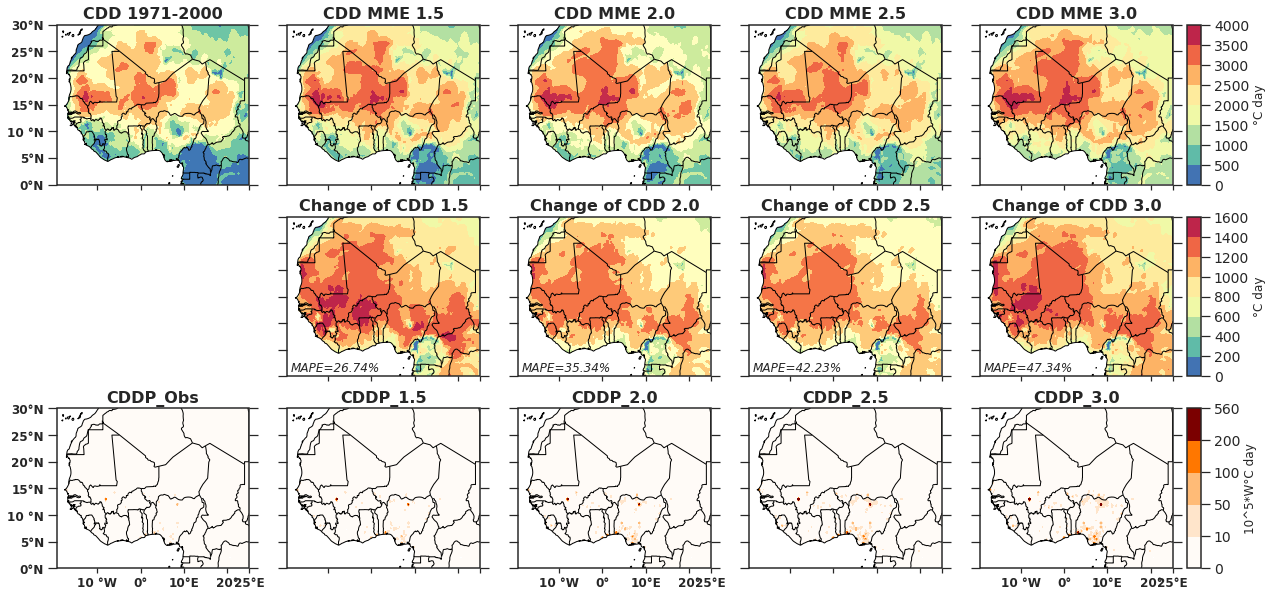

In [3626]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(3,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000,
                          transform=projection,cmap='gist_heat_r',levels=n_levels)
#     q= axes[2,i].plot(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000)

    axes[1,i].text(-18.5,1,
             str('MAPE='+
                 str(round(xs.mape(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])).values*100,
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

# for ax in axes[-1,:].flatten():
#     ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[12].get_position().x1+0.01,DP[12].get_position().y0,
                 0.01,DP[12].get_position().height])

cax2=fig.add_axes([DP[13].get_position().x1+0.01,DP[13].get_position().y0,
                 0.01,DP[13].get_position().height])

cax3=fig.add_axes([DP[14].get_position().x1+0.01,DP[14].get_position().y0,
                 0.01,DP[14].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='10^5*W\N{DEGREE SIGN}C day')
cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)


plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.png',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.svg',dpi=500)


plt.show

## Log transformation of CDDP data to smooth high outliers

In [3627]:
MME_CDDP_LOG=np.log10(MME_CDDP)

/home/ubuntu/.local/lib/python3.6/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


## Plot - Ensemean of CDDP of models per GWLs and Relative change

In [3628]:
MME_CDD.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0  \
count  17205.000000  16884.000000  16884.000000  16884.000000  16884.000000   
mean    1193.433716   1629.024878   1845.715788   2065.741280   2266.238110   
std      577.086121    643.529398    678.286501    707.371721    731.074578   
min        0.000000      0.169148      0.695934      1.660410      4.296251   
25%      770.413391   1163.654987   1344.858997   1533.094808   1707.695012   
50%     1246.676147   1698.194246   1915.725758   2138.573285   2335.192146   
75%     1657.061401   2136.451726   2379.274186   2622.802895   2843.302981   
max     2565.156982   3080.143628   3349.478469   3610.519316   3858.684569   

       spatial_ref  
count      21901.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0

In [3629]:
MME_CDD.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/summary_cdd.csv')

In [3630]:
MME_CDDP.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/summary_cddp.csv')

In [3631]:
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    426.187167    642.878077    862.903569   1063.400399
std        0.0     94.673477    136.345880    175.667625    211.872951
min        0.0      0.169148      0.695934      1.660410      4.296251
25%        0.0    364.429003    551.347729    743.899318    916.497452
50%        0.0    436.997122    658.019359    879.622955   1081.900307
75%        0.0    499.577470    754.378514   1008.167779   1234.390057
max        0.0    623.153027    915.840895   1237.221488   1544.192964

In [3632]:
MME_CDDP_LOG.to_dataframe().describe()

CDDP_Obs      CDDP_1.5      CDDP_2.0      CDDP_2.5      CDDP_3.0  \
count  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04   
mean           -inf          -inf          -inf          -inf          -inf   
std             NaN           NaN           NaN           NaN           NaN   
min            -inf          -inf          -inf          -inf          -inf   
25%    2.375578e+00  2.624232e+00  2.720349e+00  2.778959e+00  2.812753e+00   
50%    3.041925e+00  3.360534e+00  3.489982e+00  3.587072e+00  3.642660e+00   
75%    4.142279e+00  4.458215e+00  4.592951e+00  4.677539e+00  4.730829e+00   
max    7.145861e+00  7.475588e+00  7.618183e+00  7.716190e+00  7.786073e+00   

       spatial_ref  
count      21901.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0

<function matplotlib.pyplot.show>

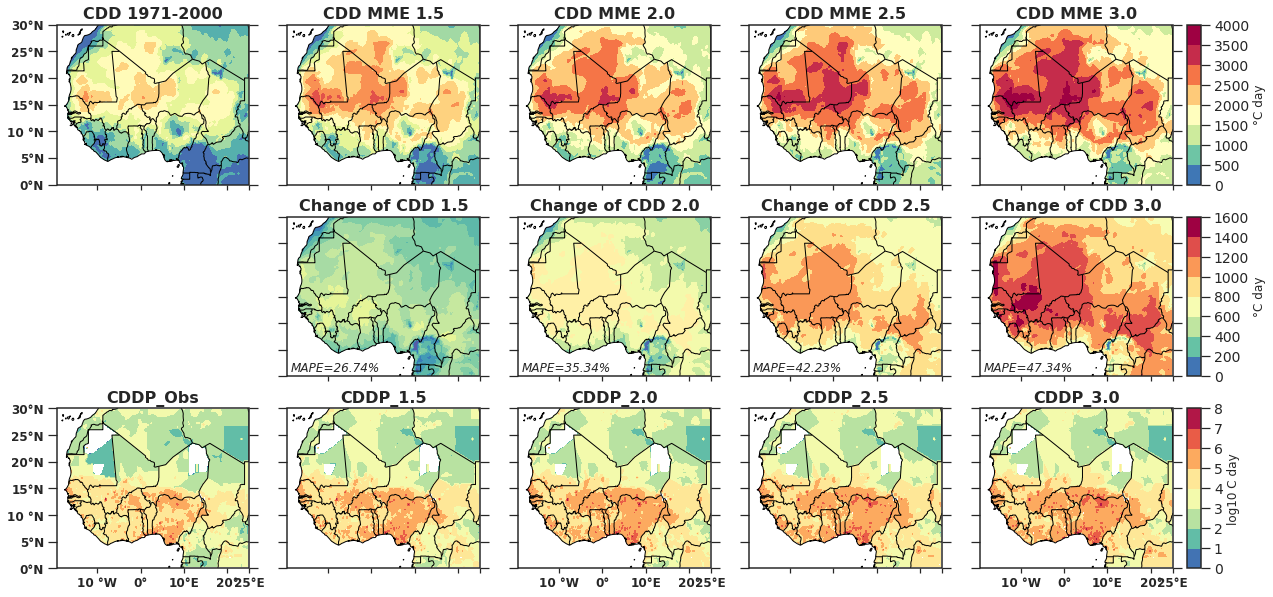

In [3633]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(3,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=1500)
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP_LOG[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r',
                          vmin=0,vmax=MME_CDDP_LOG['CDDP_3.0'].max().values)
#     q= axes[2,i].plot(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000)

    axes[1,i].text(-18.5,1,
             str('MAPE='+
                 str(round(xs.mape(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])).values*100,
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

# for ax in axes[-1,:].flatten():
#     ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[12].get_position().x1+0.01,DP[12].get_position().y0,
                 0.01,DP[12].get_position().height])

cax2=fig.add_axes([DP[13].get_position().x1+0.01,DP[13].get_position().y0,
                 0.01,DP[13].get_position().height])

cax3=fig.add_axes([DP[14].get_position().x1+0.01,DP[14].get_position().y0,
                 0.01,DP[14].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='log10 C day')
cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)

plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.png',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.svg',dpi=500)


plt.show
# https://matplotlib.org/3.5.0/gallery/subplots_axes_and_figures/colorbar_placement.html

In [3634]:
variables_cddp=['CDDP_Obs','CDDP_1.5','CDDP_2.0','CDDP_2.5','CDDP_3.0']

In [3635]:
MME_CDDP_LOG_BIAS=MME_CDDP_LOG-MME_CDDP_LOG['CDDP_Obs']

In [3636]:
MME_CDDP=MME_CDDP.drop(labels='spatial_ref')

In [3637]:
MME_CDDP_LOG.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/summary_cddp_log.csv')

In [3638]:
## Plot - Ensemean of CDDP of models per GWLs and Relative change

## CDDP plot using log transformation

In [3639]:
MME_CDDP_BIAS=MME_CDDP-MME_CDDP['CDDP_Obs']

In [3640]:
## Plot - Ensemean of CDDP of models per GWLs and Relative change

In [3641]:
import numpy as np
def relative_change(y_fut,y_obs):
    y_obs, y_fut = np.array(y_obs), np.array(y_fut)
    return np.mean(np.abs((y_fut - y_obs) / y_obs)) * 100

<function matplotlib.pyplot.show>

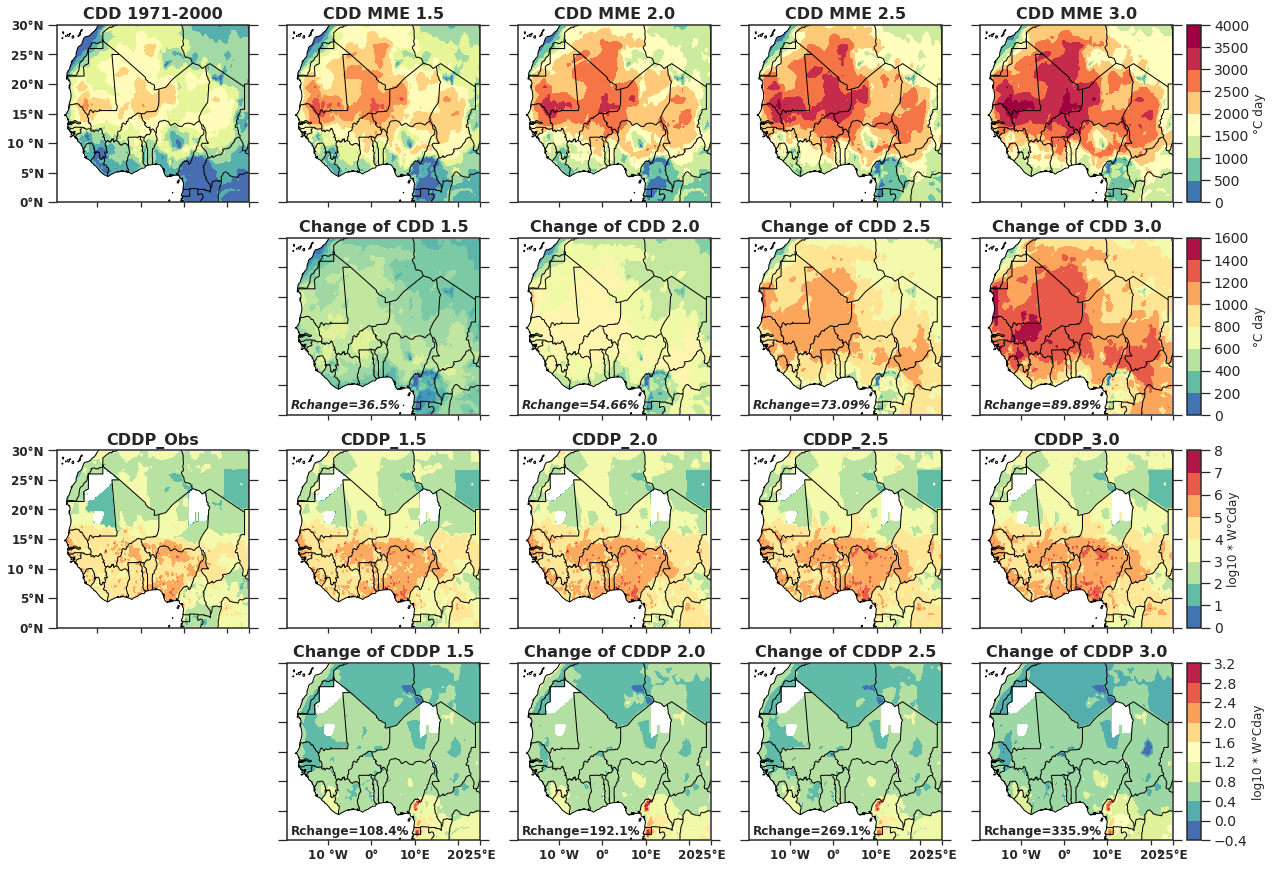

In [3642]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =14
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(4,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,15)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r',
                         vmin=0, vmax=MME_CDD_bias['MME_3.0'].max().values)
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP_LOG[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r',
                         vmin=0,vmax=MME_CDDP_LOG['CDDP_3.0'].max().values)
    r= axes[3,i].contourf(longitude, latitude,MME_CDDP_LOG_BIAS[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r')
    
    
    axes[1,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic',fontweight='bold')
    axes[3,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDDP[str(variables_cddp[i])].mean(['lon','lat']),
                                   MME_CDDP['CDDP_Obs'].mean(['lon','lat'])),
                           1))+'%'),
             fontsize=12, ha='left',fontweight='bold')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

axes[3, 0].set_visible(False)
axes[3, 0].set_axis_off()
axes[3, 1].set_title('Change of CDDP 1.5',fontsize=16,fontweight='bold')
axes[3, 2].set_title('Change of CDDP 2.0',fontsize=16,fontweight='bold')
axes[3, 3].set_title('Change of CDDP 2.5',fontsize=16,fontweight='bold')
axes[3, 4].set_title('Change of CDDP 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[16].get_position().x1+0.01,DP[16].get_position().y0,
                 0.01,DP[16].get_position().height])

cax2=fig.add_axes([DP[17].get_position().x1+0.01,DP[17].get_position().y0,
                 0.01,DP[17].get_position().height])

cax3=fig.add_axes([DP[18].get_position().x1+0.01,DP[18].get_position().y0,
                 0.01,DP[18].get_position().height])
cax4=fig.add_axes([DP[19].get_position().x1+0.01,DP[19].get_position().y0,
                 0.01,DP[19].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='log10 * W\N{DEGREE SIGN}Cday')
fig.colorbar(r, cax=cax4,label='log10 * W\N{DEGREE SIGN}Cday')
cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)
cax4.axes.tick_params(labelsize=14)



# plt.savefig('/mys3bucket/cdd_output/CDD_gwl_change_CDDP_LOG_poster.eps', format='eps')
# plt.savefig('/mys3bucket/cdd_output/CDD_gwl_change_CDDP_LOG_poster.png',dpi=300)

plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_CDDP_LOG_poster.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_CDDP_LOG_poster.png',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_CDDP_LOG_poster.svg',dpi=500)

plt.show

In [3161]:
MME_CDDP_BIAS=MME_CDDP-MME_CDDP['CDDP_Obs']
variables_cddp_label=['CDDP Obs','CDDP 1.5','CDDP 2.0','CDDP 2.5','CDDP 3.0']

<function matplotlib.pyplot.show>

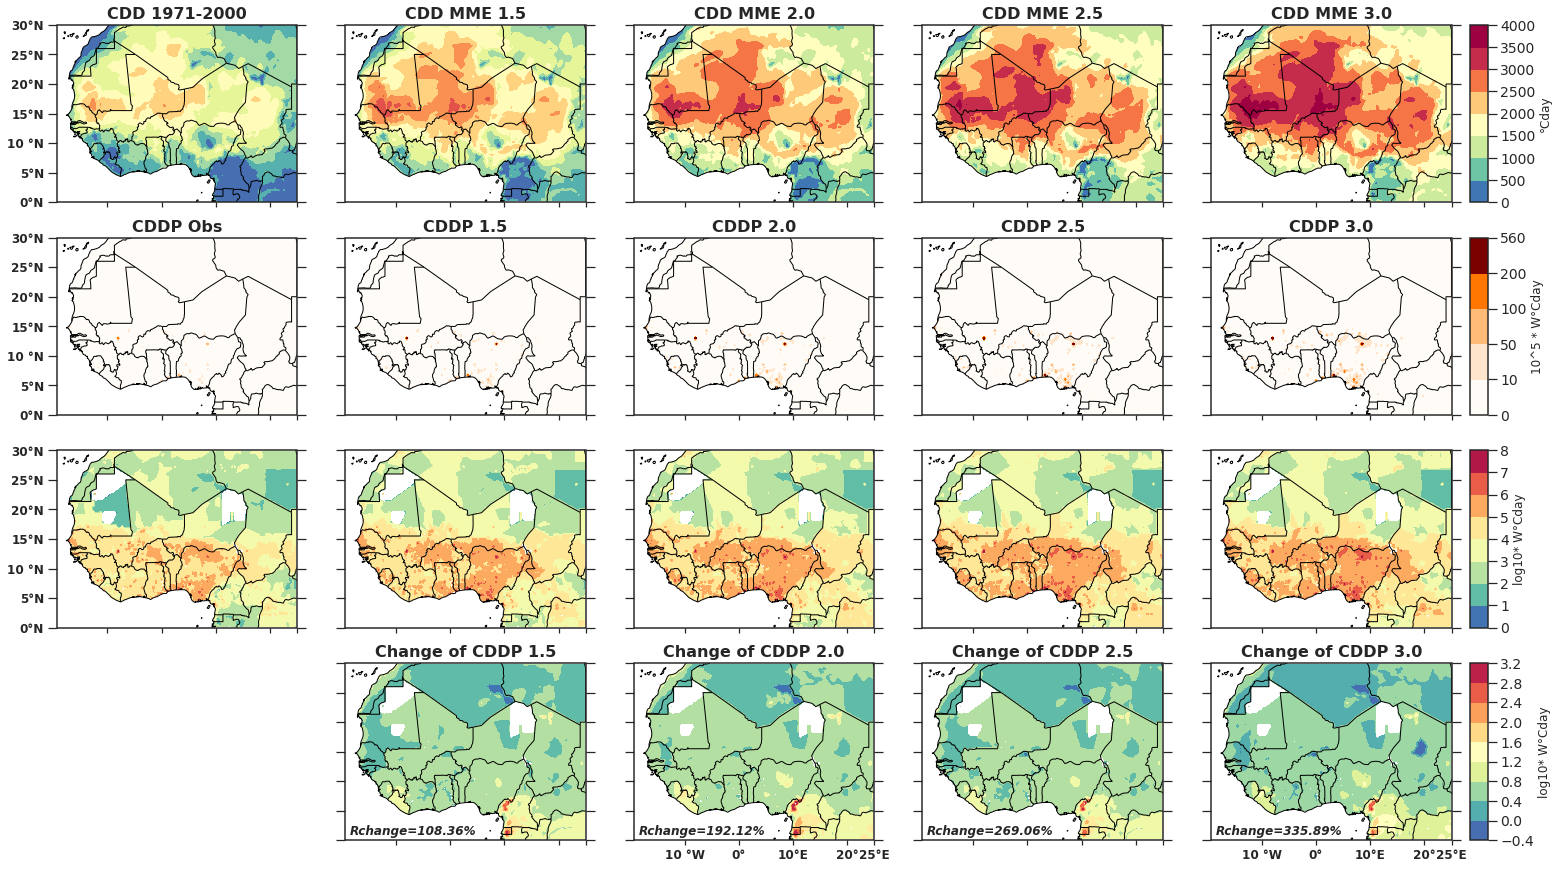

In [3643]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =16
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(4,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(25,15)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    
    p= axes[1,i].contourf(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000,
                          transform=projection,cmap='gist_heat_r',levels=n_levels)
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP_LOG[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r',
                         vmin=0,vmax=MME_CDDP_LOG['CDDP_3.0'].max().values)
    r= axes[3,i].contourf(longitude, latitude,MME_CDDP_LOG_BIAS[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r')    
    
    

    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[1,i].set_title(str(variables_cddp_label[i]),fontsize=16,fontweight='bold')
    axes[3,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDDP[str(variables_cddp[i])].mean(['lon','lat']),
                                   MME_CDDP['CDDP_Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic',fontweight='bold')
    



axes[3, 0].set_visible(False)
axes[3, 0].set_axis_off()
axes[3, 1].set_title('Change of CDDP 1.5',fontsize=16,fontweight='bold')
axes[3, 2].set_title('Change of CDDP 2.0',fontsize=16,fontweight='bold')
axes[3, 3].set_title('Change of CDDP 2.5',fontsize=16,fontweight='bold')
axes[3, 4].set_title('Change of CDDP 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

 
    
axes[3,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[3,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[16].get_position().x1+0.01,DP[16].get_position().y0,
                 0.01,DP[16].get_position().height])

cax2=fig.add_axes([DP[17].get_position().x1+0.01,DP[17].get_position().y0,
                 0.01,DP[17].get_position().height])

cax3=fig.add_axes([DP[18].get_position().x1+0.01,DP[18].get_position().y0,
                 0.01,DP[18].get_position().height])
cax4=fig.add_axes([DP[19].get_position().x1+0.01,DP[19].get_position().y0,
                 0.01,DP[19].get_position().height])
# plt.tight_layout()
# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}Cday')
fig.colorbar(p, cax=cax2,label='10^5 * W\N{DEGREE SIGN}Cday')
fig.colorbar(q, cax=cax3,label='log10* W\N{DEGREE SIGN}Cday')
fig.colorbar(r, cax=cax4,label='log10* W\N{DEGREE SIGN}Cday')
cax1.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)
cax4.axes.tick_params(labelsize=14)



plt.savefig('/mys3bucket/cdd_output/Figures/Figure11_CDDP_gwl_log_CDDP_Change_main.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/Figure11_CDDP_gwl_log_CDDP_Change_main.png',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/Figure11_CDDP_gwl_log_CDDP_Change_main.svg',dpi=1200)



plt.show

<function matplotlib.pyplot.show>

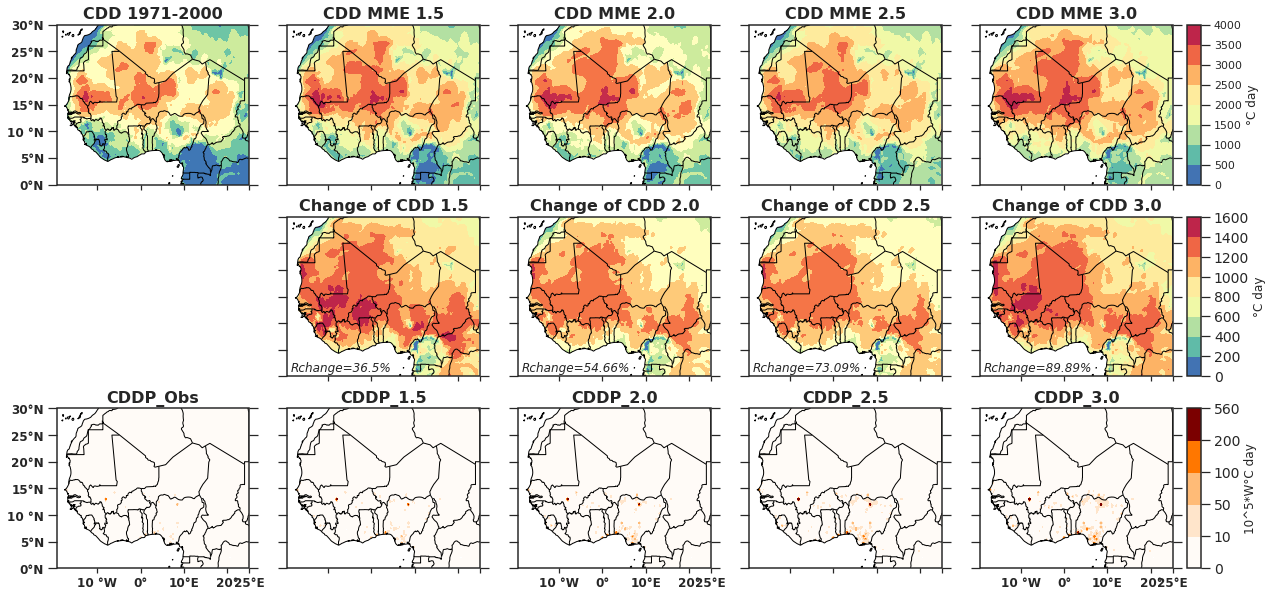

In [3644]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(3,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000,
                          transform=projection,cmap='gist_heat_r',levels=n_levels)
#     q= axes[2,i].plot(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000)

    axes[1,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels,fontsize=12,fontweight='bold')
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels,fontsize=12,fontweight='bold')
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

# for ax in axes[-1,:].flatten():
#     ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[12].get_position().x1+0.01,DP[12].get_position().y0,
                 0.01,DP[12].get_position().height])

cax2=fig.add_axes([DP[13].get_position().x1+0.01,DP[13].get_position().y0,
                 0.01,DP[13].get_position().height])

cax3=fig.add_axes([DP[14].get_position().x1+0.01,DP[14].get_position().y0,
                 0.01,DP[14].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='10^5*W\N{DEGREE SIGN}C day')
cax2.axes.tick_params(labelsize=14)
cax2.axes.tick_params(labelsize=14)
cax3.axes.tick_params(labelsize=14)



plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new_plus.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new_plus_transparent.png',transparent=True,dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new_plus.png',dpi=500)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new_plus.svg',dpi=500)


plt.show

## Descriptive statistics

In [3645]:
MME_CDDP.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/MME_CDDP_gwl.csv')
MME_CDDP.to_dataframe().describe()

CDDP_Obs      CDDP_1.5      CDDP_2.0      CDDP_2.5      CDDP_3.0
count  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04
mean   2.460764e+04  5.127183e+04  7.188360e+04  9.081768e+04  1.072622e+05
std    1.820032e+05  3.849762e+05  5.462495e+05  7.001506e+05  8.397754e+05
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    2.374534e+02  4.209516e+02  5.252293e+02  6.011171e+02  6.497595e+02
50%    1.101350e+03  2.293685e+03  3.090164e+03  3.864311e+03  4.391973e+03
75%    1.387647e+04  2.872204e+04  3.916975e+04  4.759254e+04  5.380585e+04
max    1.399140e+07  2.989428e+07  4.151289e+07  5.202232e+07  6.110453e+07

In [3646]:
MME_CDDP.to_dataframe().describe(percentiles=[.1, .25, .5, .75, .80,.85,.90,.95]).to_csv('/mys3bucket/cdd_output/MME_CDDP_gwl_detail.csv')
MME_CDDP.to_dataframe().describe(percentiles=[.1, .25, .5, .75, .80,.85,.90,.95])

CDDP_Obs      CDDP_1.5      CDDP_2.0      CDDP_2.5      CDDP_3.0
count  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04
mean   2.460764e+04  5.127183e+04  7.188360e+04  9.081768e+04  1.072622e+05
std    1.820032e+05  3.849762e+05  5.462495e+05  7.001506e+05  8.397754e+05
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
10%    6.218456e+01  1.412726e+02  1.718679e+02  1.923053e+02  2.086024e+02
25%    2.374534e+02  4.209516e+02  5.252293e+02  6.011171e+02  6.497595e+02
50%    1.101350e+03  2.293685e+03  3.090164e+03  3.864311e+03  4.391973e+03
75%    1.387647e+04  2.872204e+04  3.916975e+04  4.759254e+04  5.380585e+04
80%    2.325561e+04  4.698926e+04  6.315842e+04  7.763204e+04  8.920254e+04
85%    3.476272e+04  7.004771e+04  9.472485e+04  1.156280e+05  1.315964e+05
90%    5.439270e+04  1.112680e+05  1.537132e+05  1.927721e+05  2.226522e+05
95%    9.816946e+04  2.025668e+05  2.855584e+05  3.597572e+05  4.266021e+05
max    1.399140e+07  2.989428e+07  4.151289e+07  5.202232e+07  6.110453e+07

In [3648]:
# convert into standard CRS 
all_files.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:       (lat: 121, lon: 181)
Coordinates:
  * lon           (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat           (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref   int64 0
Data variables:
    CDDP_Obs      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_1.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_3.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Obs           (lat, lon) float32 nan nan nan nan ... 169.8 133.2 131.4 134.9
    MME_1.5       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Obs_bias      (lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    MME_1.5_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [3649]:
# convert into standard CRS 
all_files.rio.write_crs("epsg:4326", inplace=True)

temp_country = {}
small_countries = []
for i in range(states_gdf.shape[0]):
    data = states_gdf[states_gdf.index==i]
    try:
        clip = all_files.rio.clip(data.geometry.apply(mapping), data.crs).mean(dim=['lon','lat'])
        temp_country[states_gdf.iloc[i]['NAME']] = clip
        
    except:
        small_countries.append(states_gdf.iloc[i]['NAME'])


dd=pd.DataFrame()
for key in temp_country.keys():
    tmp=temp_country[key]
    tmp2=tmp.expand_dims("Country").to_dataframe().reset_index().drop(columns='spatial_ref')
    tmp2['Country']=str(key)
    
    dd=dd.append(tmp2)

In [3650]:
dd.to_csv('/mys3bucket/cdd_output/summary_cdd_country_new.csv')

In [3651]:
# dd

In [3652]:
## Prepare datasets

In [3653]:
cddp_mme=dd[['Country','CDDP_Obs','CDDP_1.5','CDDP_2.0','CDDP_2.5','CDDP_3.0']]
cdd_mme=dd[['Country','Obs','MME_1.5','MME_2.0','MME_2.5','MME_3.0']]

In [3654]:
cddp_mme_r=cddp_mme.melt(id_vars=["Country"], var_name="cddp_case")
cddp_mme.melt(id_vars=["Country"], var_name="cddp_case")

cdd_mme_r=cdd_mme.melt(id_vars=["Country"], var_name="cdd_case")
cdd_mme.melt(id_vars=["Country"], var_name="cdd_case")

Country cdd_case        value
0                    Chad      Obs  1378.632935
1            Sierra Leone      Obs   594.749329
2                  Guinea      Obs   674.160828
3    Central African Rep.      Obs   577.518066
4                 Nigeria      Obs  1065.368652
..                    ...      ...          ...
120               Liberia  MME_3.0  1214.658514
121               Morocco  MME_3.0  1238.053974
122                  Mali  MME_3.0  3149.663603
123                 Niger  MME_3.0  2679.151680
124             W. Sahara  MME_3.0  1933.352488

[125 rows x 3 columns]

In [3655]:
## CDDP by country and by warming levels

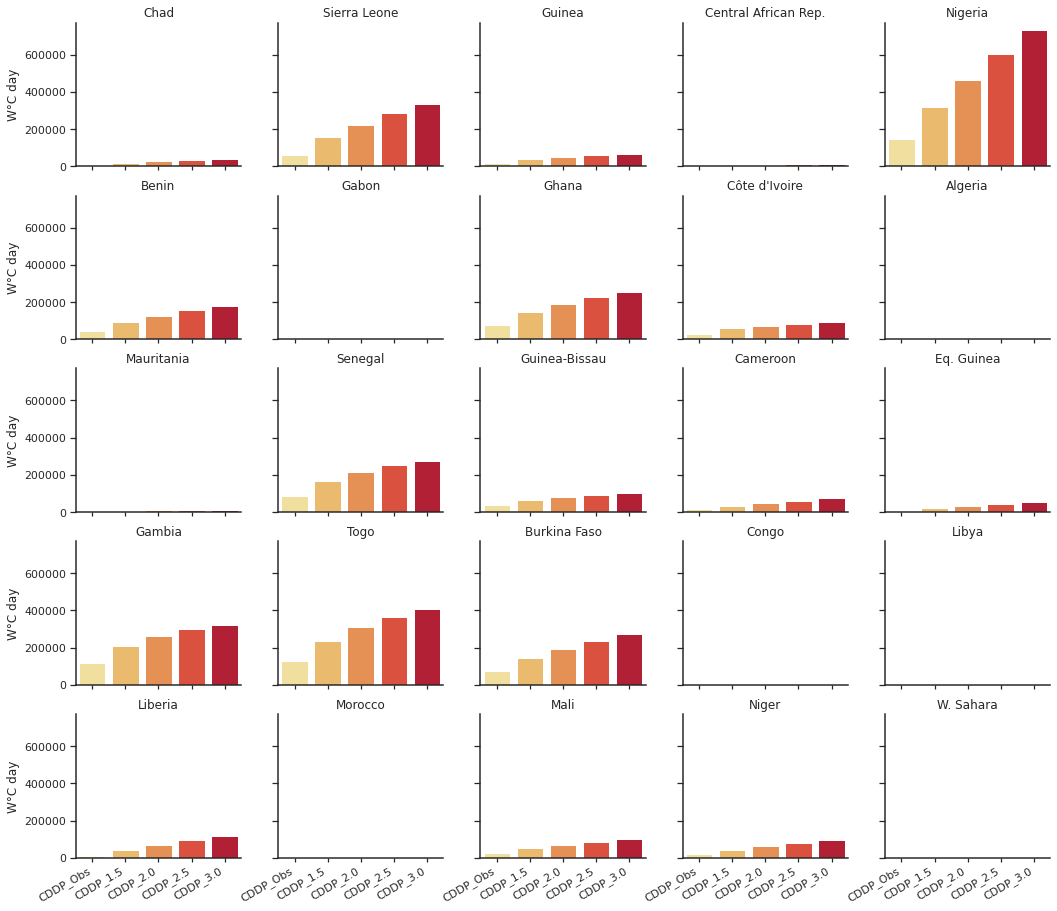

In [3657]:
custom_params = {"axes.linewidth":1.5,"xtick.major.size":4}
times = cddp_mme_r.cddp_case.unique()
sns.set_theme(style="ticks",rc=custom_params)
g = sns.FacetGrid(cddp_mme_r, col="Country",col_wrap=5)
g.map(sns.barplot,"cddp_case","value",order=times,palette='YlOrRd')
g.set_titles("{col_name}")
g.set(xlabel=None,ylabel='W\N{DEGREE SIGN}C day')
# g.despine(top=True)
# g.despine(left=True)
g.fig.autofmt_xdate()
plt.savefig('/mys3bucket/cdd_output/Figures/Figure_12_CDDP_country.svg',dpi=300)
plt.savefig('/mys3bucket/cdd_output/Figures/Figure_12_CDDP_country.png',dpi=500)

## CDD by country and by warming levels

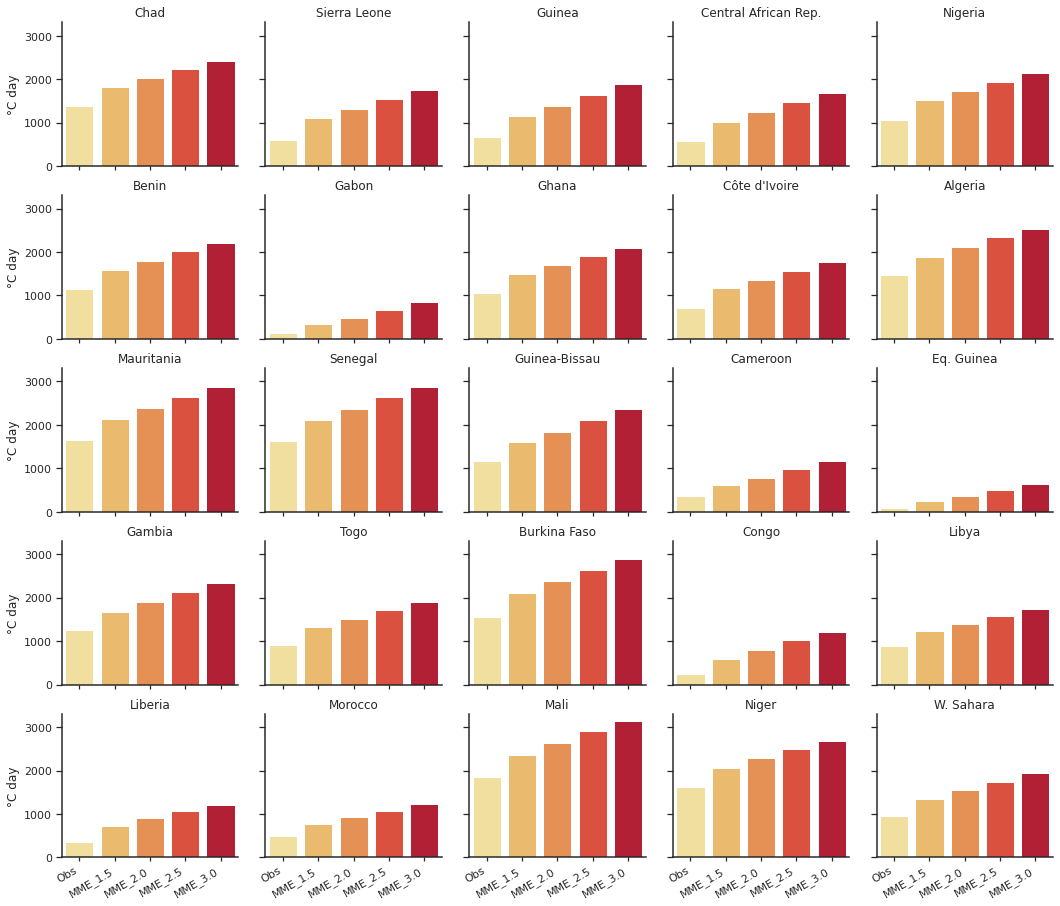

In [3659]:
custom_params = {"axes.linewidth":1.5,"xtick.major.size":4}
times = cdd_mme_r.cdd_case.unique()
sns.set_theme(style="ticks",rc=custom_params)
g = sns.FacetGrid(cdd_mme_r, col="Country",col_wrap=5)
g.map(sns.barplot,"cdd_case","value",order=times,palette='YlOrRd')
g.set_titles("{col_name}")
g.set(xlabel=None,ylabel='\N{DEGREE SIGN}C day')
# g.despine(top=True)
# g.despine(left=True)
g.fig.autofmt_xdate()
plt.savefig('/mys3bucket/cdd_output/Figures/Figure10_CDD_country.svg',dpi=300)
plt.savefig('/mys3bucket/cdd_output/Figures/Figure10_CDD_country.png',dpi=600)